<a href="https://colab.research.google.com/github/stemlock/w266_final_project/blob/master/Error_Analysis_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')
CWD = '/content/drive/My Drive/W266 Final Project/Code'

%cd $CWD

Mounted at /content/drive
/content/drive/My Drive/W266 Final Project/Code


In [2]:
%%capture
!pip install transformers==4.12.2;
!pip install tensorflow==2.5.2;

In [3]:
# Imports
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve

import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

In [4]:
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.5.2


In [ ]:
# print("Transformers version:", transformers.__version__)

In [5]:
# Set random seed
seed = 42

## Load Data

In [6]:
# Read in processed data (Rows with NA in the neutral_review_text had no tokens replaced)
df_test = pd.read_csv('data/model_test.csv')

## Baseline Metrics

### Majority tokens average

In [ ]:
# Extract the male vs female majority texts
df_female_majority = df_test[df_test['male_sub_count'] > df_test['female_sub_count']]
df_male_majority = df_test[df_test['male_sub_count'] < df_test['female_sub_count']]

In [ ]:
# Average sentiment for female majority texts
print("Average female review binary sentiment:", df_female_majority['label'].mean())

Average female review binary sentiment: 0.4896039603960396


In [ ]:
# Average review score for female majority texts
print("Average female review score 1-10:", df_female_majority['review_score'].mean())

Average female review score 1-10: 5.436138613861386


In [ ]:
# Average sentiment for male majority texts
print("Average male review binary sentiment:", df_male_majority['label'].mean())

Average male review binary sentiment: 0.5035229420862691


In [ ]:
# Average review score for male majority texts
print("Average male review score 1-10:", df_male_majority['review_score'].mean())

Average male review score 1-10: 5.509709572091425


In [ ]:
# Distribution of scores across review scores for female majority texts
df_female_majority['review_score'].value_counts()/len(df_female_majority)

1     0.181683
10    0.171782
8     0.121287
4     0.121287
3     0.111386
7     0.106931
2     0.096040
9     0.089604
Name: review_score, dtype: float64

In [ ]:
# Distribution of scores across review scores for male majority texts
df_male_majority['review_score'].value_counts()/len(df_male_majority)

1     0.197457
10    0.190067
8     0.120124
4     0.105860
3     0.101564
7     0.100361
9     0.092971
2     0.091596
Name: review_score, dtype: float64

### Proportional weighted average

In [ ]:
# Extract the proportion of male vs female tokens per review
male_proportion = (df_test['female_sub_count']/df_test['neutral_sub_count'])
female_proportion = (df_test['male_sub_count']/df_test['neutral_sub_count'])

In [ ]:
# Weighted average sentiment for female tokens
(df_test['label']*female_proportion).sum()/female_proportion.sum()

0.4922782109404571

In [ ]:
# Weighted average review scores for female tokens
(df_test['review_score']*female_proportion).sum()/female_proportion.sum()

5.440864712868192

In [ ]:
# Weighted average sentiment for male tokens
(df_test['label']*male_proportion).sum()/male_proportion.sum()

0.5028605798629667

In [ ]:
# Weighted average review scores for male tokens
(df_test['review_score']*male_proportion).sum()/male_proportion.sum()

5.508159425039407

## Data Transformations

### Split data and encode

In [16]:
# Load data
test_texts = df_test['review_text'].values.tolist()
n_test_texts = df_test['neutral_review_text'].values.tolist()
f_test_texts = df_test['female_review_text'].values.tolist()
m_test_texts = df_test['male_review_text'].values.tolist()
test_labels = df_test['label'].values.tolist()

In [17]:
# Create dev set from portion of test set using split
_, test_texts, _, _ = train_test_split(test_texts, test_labels, test_size=.5, random_state=seed)
_, n_test_texts, _, _ = train_test_split(n_test_texts, test_labels, test_size=.5, random_state=seed)
_, f_test_texts, _, _ = train_test_split(f_test_texts, test_labels, test_size=.5, random_state=seed)
_, m_test_texts, _, test_labels = train_test_split(m_test_texts, test_labels, test_size=.5, random_state=seed)

In [18]:
# Specify tokenizer and batch encode the datasets
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors='tf')
n_test_encodings = tokenizer(n_test_texts, truncation=True, padding=True, return_tensors='tf')
m_test_encodings = tokenizer(m_test_texts, truncation=True, padding=True, return_tensors='tf')
f_test_encodings = tokenizer(f_test_texts, truncation=True, padding=True, return_tensors='tf')

### Create TF.Datasets

In [19]:
# Change labels list into tf.Tensors
tf_test_labels = tf.convert_to_tensor(test_labels)

In [20]:
# Turn encodings into datasets for easy batching
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    tf_test_labels
)).batch(16)

n_test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(n_test_encodings),
    tf_test_labels
)).batch(16)

m_test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(m_test_encodings),
    tf_test_labels
)).batch(16)

f_test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(f_test_encodings),
    tf_test_labels
)).batch(16)

## Model Pipeline

### Initiliaze TF strategy (TPU preferred)

In [21]:
# Initialize the TPU devices
if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')

INFO:tensorflow:Initializing the TPU system: grpc://10.56.199.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.56.199.218:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Using TPU


### Baseline Model v3 (5 epochs + 1e-5 learning rate)

#### Load and Initialize Models

In [22]:
# Starter function to create the model (we can improve on this when we start using more complex models)
def load_model(path):

  return TFDistilBertForSequenceClassification.from_pretrained(path, num_labels=2)

In [23]:
orig_path = CWD + "/models/original_base_model_v3"
unk_path = CWD + "/models/UNK_base_model_v3"
paths = [orig_path, unk_path]
models = []

for path in paths:
  with strategy.scope():
      model = load_model(path)

      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

      model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                    metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])
      
      models.append(model)

original_model, unk_model = models

Some layers from the model checkpoint at /content/drive/My Drive/W266 Final Project/Code/models/original_base_model_v3 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/My Drive/W266 Final Project/Code/models/original_base_model_v3 and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to b

#### Test metrics

In [24]:
# Evaluate the original baseline model
original_model.evaluate(x=test_dataset)

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=int32>]


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


262/262 [==============================] - 17s 22ms/step - loss: 0.2439 - accuracy: 0.9283


[0.24386228621006012, 0.9282811880111694]

In [25]:
# Evaluate the UNK baseline model
unk_model.evaluate(x=test_dataset)

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=int32>]


262/262 [==============================] - 14s 22ms/step - loss: 0.2386 - accuracy: 0.9285


[0.23861606419086456, 0.9285202026367188]

#### Sentiment 

In [26]:
# Get the logits for both models on all datasets respectively
orig_logit_preds = original_model.predict(x=test_dataset).logits
orig_n_logit_preds = original_model.predict(x=n_test_dataset).logits
orig_m_logit_preds = original_model.predict(x=m_test_dataset).logits
orig_f_logit_preds = original_model.predict(x=f_test_dataset).logits

unk_logit_preds = unk_model.predict(x=test_dataset).logits
unk_n_logit_preds = unk_model.predict(x=n_test_dataset).logits
unk_m_logit_preds = unk_model.predict(x=m_test_dataset).logits
unk_f_logit_preds = unk_model.predict(x=f_test_dataset).logits

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=int32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=int32>]


In [27]:
# Get the average sentiments for the original model on original data vs UNK data
orig_pred_probs = tf.math.softmax(orig_logit_preds, axis=-1)
orig_n_pred_probs = tf.math.softmax(orig_n_logit_preds, axis=-1)

print("Average Original Positive Sentiment:", np.mean(orig_pred_probs[:,1]))
print("Average Neutral Positive Sentiment:", np.mean(orig_n_pred_probs[:,1]))
print("Difference in Sentiment (Original - Neutral):", np.mean(orig_pred_probs[:,1])-np.mean(orig_n_pred_probs[:,1]))

Average Original Positive Sentiment: 0.5319944
Average Neutral Positive Sentiment: 0.5322388
Difference in Sentiment (Original - Neutral): -0.00024437904


In [28]:
# Get the average sentiments for the original model on male vs female
orig_m_pred_probs = tf.math.softmax(orig_m_logit_preds, axis=-1)
orig_f_pred_probs = tf.math.softmax(orig_f_logit_preds, axis=-1)

print("Average Male Positive Sentiment:", np.mean(orig_m_pred_probs[:,1]))
print("Average Female Positive Sentiment:", np.mean(orig_f_pred_probs[:,1]))
print("Difference in Sentiment (Male - Female):", np.mean(orig_m_pred_probs[:,1])-np.mean(orig_f_pred_probs[:,1]))

Average Male Positive Sentiment: 0.53320444
Average Female Positive Sentiment: 0.53076464
Difference in Sentiment (Male - Female): 0.002439797


In [29]:
# Get the average sentiments for the UNK model on original data vs UNK data
unk_pred_probs = tf.math.softmax(unk_logit_preds, axis=-1)
unk_n_pred_probs = tf.math.softmax(unk_n_logit_preds, axis=-1)

print("Average Original Positive Sentiment:", np.mean(unk_pred_probs[:,1]))
print("Average Neutral Positive Sentiment:", np.mean(unk_n_pred_probs[:,1]))
print("Difference in Sentiment (Original - Neutral):", np.mean(unk_pred_probs[:,1])-np.mean(unk_n_pred_probs[:,1]))

Average Original Positive Sentiment: 0.53993326
Average Neutral Positive Sentiment: 0.5400626
Difference in Sentiment (Original - Neutral): -0.00012934208


In [30]:
# Get the average sentiments for the unknown model on male vs female
unk_m_pred_probs = tf.math.softmax(unk_m_logit_preds, axis=-1)
unk_f_pred_probs = tf.math.softmax(unk_f_logit_preds, axis=-1)

print("Average Male Positive Sentiment:", np.mean(unk_m_pred_probs[:,1]))
print("Average Female Positive Sentiment:", np.mean(unk_f_pred_probs[:,1]))
print("Difference in Sentiment (Male - Female):", np.mean(unk_m_pred_probs[:,1])-np.mean(unk_f_pred_probs[:,1]))

Average Male Positive Sentiment: 0.5398214
Average Female Positive Sentiment: 0.5396367
Difference in Sentiment (Male - Female): 0.0001847148


## Error Analysis

In [299]:
# Get the models' predictions
orig_preds = np.where(orig_pred_probs[:,1] >= 0.5, 1, 0)
orig_n_preds = np.where(orig_n_pred_probs[:,1] >= 0.5, 1, 0)
orig_m_preds = np.where(orig_m_pred_probs[:,1] >= 0.5, 1, 0)
orig_f_preds = np.where(orig_f_pred_probs[:,1] >= 0.5, 1, 0)

unk_preds = np.where(unk_pred_probs[:,1] >= 0.5, 1, 0)
unk_n_preds = np.where(unk_n_pred_probs[:,1] >= 0.5, 1, 0)
unk_m_preds = np.where(unk_m_pred_probs[:,1] >= 0.5, 1, 0)
unk_f_preds = np.where(unk_f_pred_probs[:,1] >= 0.5, 1, 0)

# Get the models' scores
orig_scores = (orig_preds == test_labels).astype(int)
orig_n_scores = (orig_n_preds == test_labels).astype(int)
orig_m_scores = (orig_m_preds == test_labels).astype(int)
orig_f_scores = (orig_f_preds == test_labels).astype(int)

unk_scores = (unk_preds == test_labels).astype(int)
unk_n_scores = (unk_n_preds == test_labels).astype(int)
unk_m_scores = (unk_m_preds == test_labels).astype(int)
unk_f_scores = (unk_f_preds == test_labels).astype(int)

# Get the model errors
orig_errors = np.where(orig_scores == 0)[0]
orig_n_errors = np.where(orig_n_scores == 0)[0]
orig_m_errors = np.where(orig_m_scores == 0)[0]
orig_f_errors = np.where(orig_f_scores == 0)[0]

unk_errors = np.where(unk_scores == 0)[0]
unk_n_errors = np.where(unk_n_scores == 0)[0]
unk_m_errors = np.where(unk_m_scores == 0)[0]
unk_f_errors = np.where(unk_f_scores == 0)[0]

### Confusion Matrices

#### Original Model

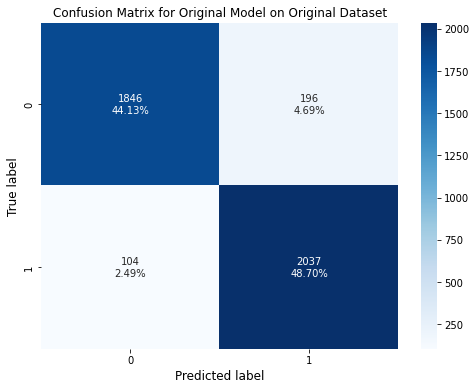

In [ ]:
cm_orig = confusion_matrix(test_labels, orig_preds)

group_counts = [f"{value}" for value in cm_orig.flatten()]
group_percentages = [f"{value:.2%}" for value in 
                     cm_orig.flatten()/np.sum(cm_orig)]
labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in 
          zip(group_counts,group_percentages)]).reshape(2,2)

plt.figure(figsize=(8,6))
sns.heatmap(cm_orig, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":10})

plt.title("Confusion Matrix for Original Model on Original Dataset")
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.show()

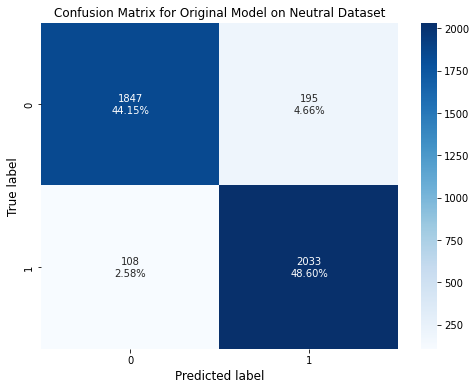

In [ ]:
cm_orig_n = confusion_matrix(test_labels, orig_n_preds)

group_counts = [f"{value}" for value in cm_orig_n.flatten()]
group_percentages = [f"{value:.2%}" for value in 
                     cm_orig_n.flatten()/np.sum(cm_orig_n)]
labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in 
          zip(group_counts,group_percentages)]).reshape(2,2)

plt.figure(figsize=(8,6))
sns.heatmap(cm_orig_n, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":10})

plt.title("Confusion Matrix for Original Model on Neutral Dataset")
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.show()

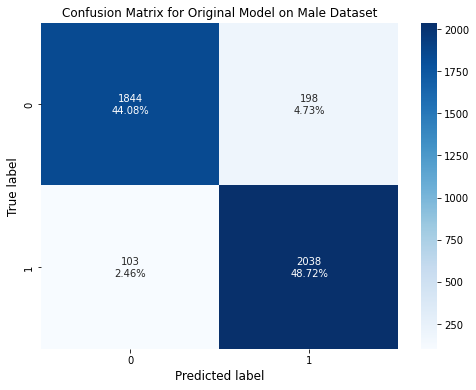

In [ ]:
cm_orig_m = confusion_matrix(test_labels, orig_m_preds)

group_counts = [f"{value}" for value in cm_orig_m.flatten()]
group_percentages = [f"{value:.2%}" for value in 
                     cm_orig_m.flatten()/np.sum(cm_orig_m)]
labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in 
          zip(group_counts,group_percentages)]).reshape(2,2)

plt.figure(figsize=(8,6))
sns.heatmap(cm_orig_m, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":10})

plt.title("Confusion Matrix for Original Model on Male Dataset")
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.show()

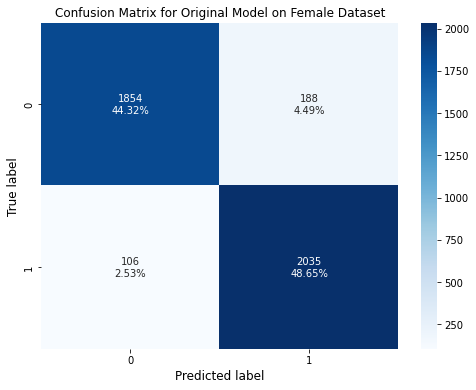

In [ ]:
cm_orig_f = confusion_matrix(test_labels, orig_f_preds)

group_counts = [f"{value}" for value in cm_orig_f.flatten()]
group_percentages = [f"{value:.2%}" for value in 
                     cm_orig_f.flatten()/np.sum(cm_orig_f)]
labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in 
          zip(group_counts,group_percentages)]).reshape(2,2)

plt.figure(figsize=(8,6))
sns.heatmap(cm_orig_f, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":10})

plt.title("Confusion Matrix for Original Model on Female Dataset")
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.show()

#### Neutral Model

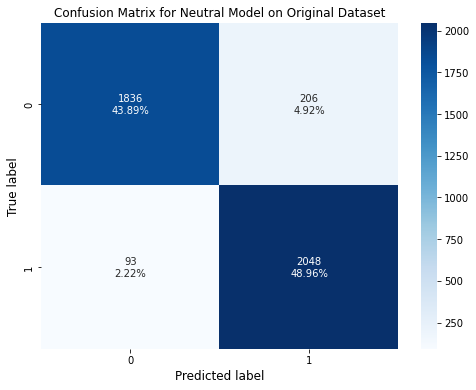

In [ ]:
cm_unk = confusion_matrix(test_labels, unk_preds)

group_counts = [f"{value}" for value in cm_unk.flatten()]
group_percentages = [f"{value:.2%}" for value in 
                     cm_unk.flatten()/np.sum(cm_unk)]
labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in 
          zip(group_counts,group_percentages)]).reshape(2,2)

plt.figure(figsize=(8,6))
sns.heatmap(cm_unk, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":10})

plt.title("Confusion Matrix for Neutral Model on Original Dataset")
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.show()

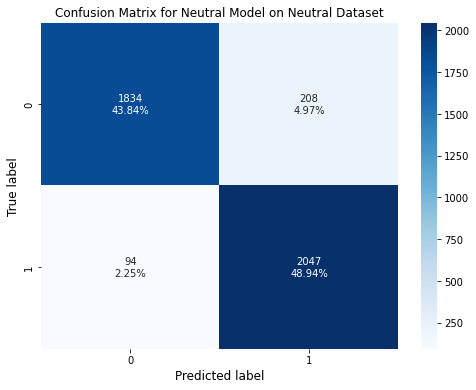

In [ ]:
cm_unk_n = confusion_matrix(test_labels, unk_n_preds)

group_counts = [f"{value}" for value in cm_unk_n.flatten()]
group_percentages = [f"{value:.2%}" for value in 
                     cm_unk_n.flatten()/np.sum(cm_unk_n)]
labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in 
          zip(group_counts,group_percentages)]).reshape(2,2)

plt.figure(figsize=(8,6))
sns.heatmap(cm_unk_n, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":10})

plt.title("Confusion Matrix for Neutral Model on Neutral Dataset")
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.show()

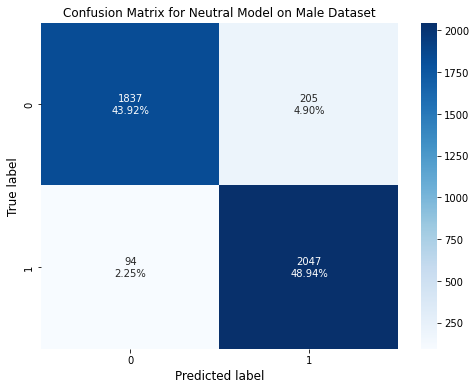

In [ ]:
cm_unk_m = confusion_matrix(test_labels, unk_m_preds)

group_counts = [f"{value}" for value in cm_unk_m.flatten()]
group_percentages = [f"{value:.2%}" for value in 
                     cm_unk_m.flatten()/np.sum(cm_unk_m)]
labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in 
          zip(group_counts,group_percentages)]).reshape(2,2)

plt.figure(figsize=(8,6))
sns.heatmap(cm_unk_m, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":10})

plt.title("Confusion Matrix for Neutral Model on Male Dataset")
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.show()

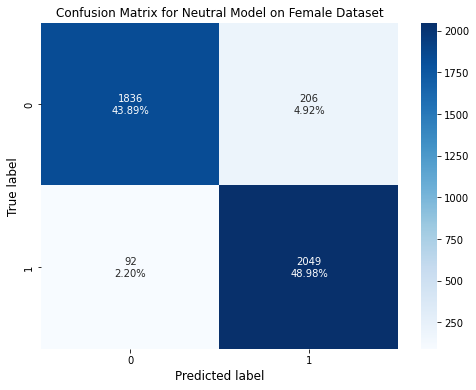

In [ ]:
cm_unk_f = confusion_matrix(test_labels, unk_f_preds)

group_counts = [f"{value}" for value in cm_unk_f.flatten()]
group_percentages = [f"{value:.2%}" for value in 
                     cm_unk_f.flatten()/np.sum(cm_unk_f)]
labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in 
          zip(group_counts,group_percentages)]).reshape(2,2)

plt.figure(figsize=(8,6))
sns.heatmap(cm_unk_f, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":10})

plt.title("Confusion Matrix for Neutral Model on Female Dataset")
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.show()

#### Combined Plots

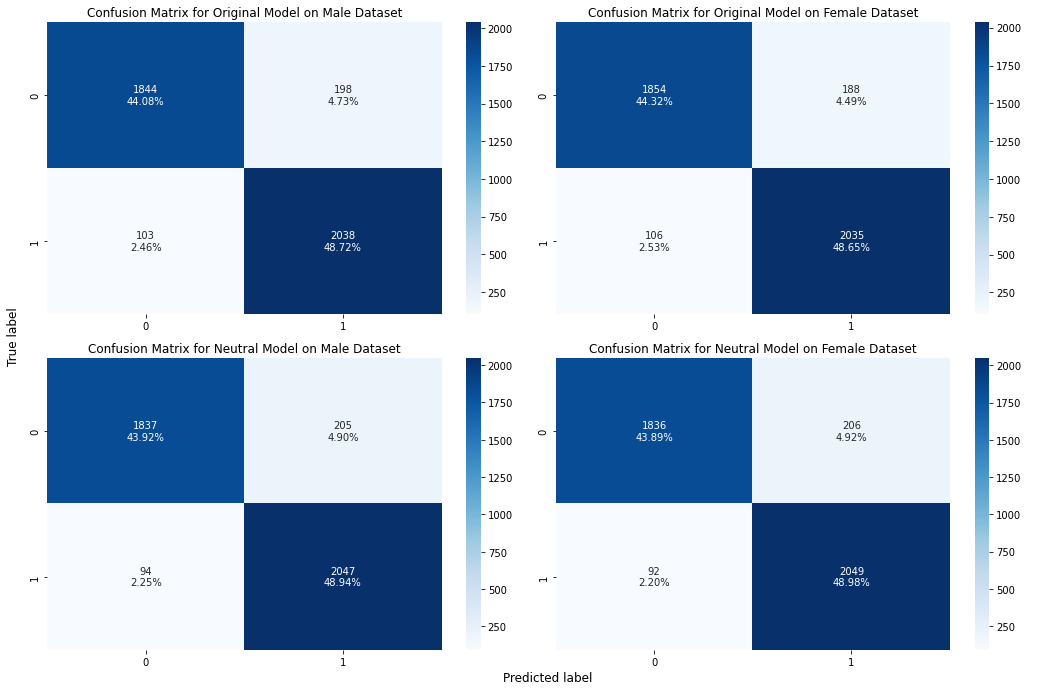

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=False, sharey=False)
preds = (orig_m_preds, orig_f_preds, unk_m_preds, unk_f_preds)
titles = [('Original', 'Male'), ('Original', 'Female'), ('Neutral', 'Male'), ('Neutral', 'Female')]

for ax, pred, title in zip(axes.flat, preds, titles):
  cm = confusion_matrix(test_labels, pred)
  group_counts = [f"{value}" for value in cm.flatten()]
  group_percentages = [f"{value:.2%}" for value in 
                      cm.flatten()/np.sum(cm)]
  labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in 
            zip(group_counts,group_percentages)]).reshape(2,2)

  sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":10}, ax=ax) 
  ax.title.set_text(f"Confusion Matrix for {title[0]} Model on {title[1]} Dataset")

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.tight_layout()  
plt.show()

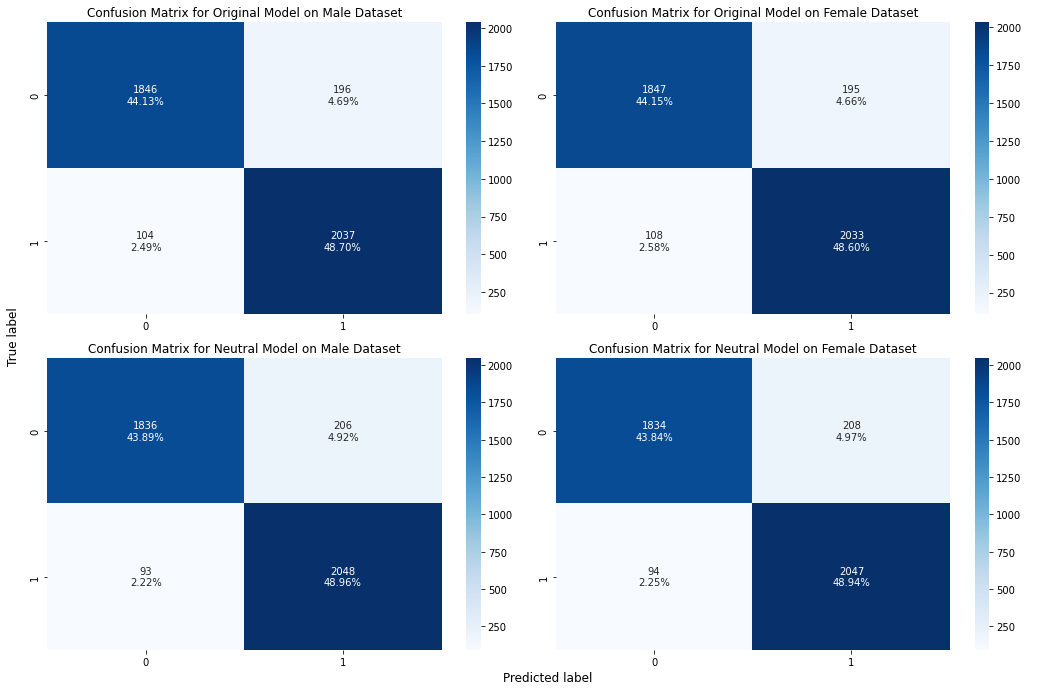

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=False, sharey=False)
preds = (orig_preds, orig_n_preds, unk_preds, unk_n_preds)
titles = [('Original', 'Male'), ('Original', 'Female'), ('Neutral', 'Male'), ('Neutral', 'Female')]

for ax, pred, title in zip(axes.flat, preds, titles):
  cm = confusion_matrix(test_labels, pred)
  group_counts = [f"{value}" for value in cm.flatten()]
  group_percentages = [f"{value:.2%}" for value in 
                      cm.flatten()/np.sum(cm)]
  labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in 
            zip(group_counts,group_percentages)]).reshape(2,2)

  sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":10}, ax=ax) 
  ax.title.set_text(f"Confusion Matrix for {title[0]} Model on {title[1]} Dataset")

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.tight_layout()  
plt.show()

### Calibration Curve

#### Original Model

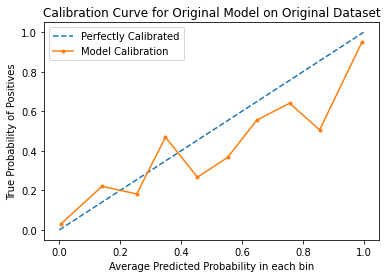

In [ ]:
prob_true, prob_pred = calibration_curve(test_labels, orig_pred_probs[:,1], n_bins = 10)

# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfectly Calibrated')
 
# Plot model's calibration curve
plt.plot(prob_pred, prob_true, marker = '.', label = 'Model Calibration')
 
leg = plt.legend(loc = 'upper left')
plt.title('Calibration Curve for Original Model on Original Dataset')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('True Probability of Positives')
plt.show()

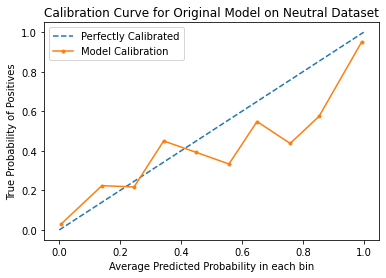

In [ ]:
prob_true, prob_pred = calibration_curve(test_labels, orig_n_pred_probs[:,1], n_bins = 10)

# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfectly Calibrated')
 
# Plot model's calibration curve
plt.plot(prob_pred, prob_true, marker = '.', label = 'Model Calibration')
 
leg = plt.legend(loc = 'upper left')
plt.title('Calibration Curve for Original Model on Neutral Dataset')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('True Probability of Positives')
plt.show()

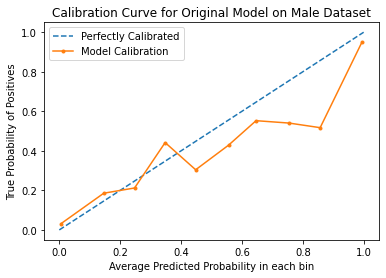

In [ ]:
prob_true, prob_pred = calibration_curve(test_labels, orig_m_pred_probs[:,1], n_bins = 10)

# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfectly Calibrated')
 
# Plot model's calibration curve
plt.plot(prob_pred, prob_true, marker = '.', label = 'Model Calibration')
 
leg = plt.legend(loc = 'upper left')
plt.title('Calibration Curve for Original Model on Male Dataset')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('True Probability of Positives')
plt.show()

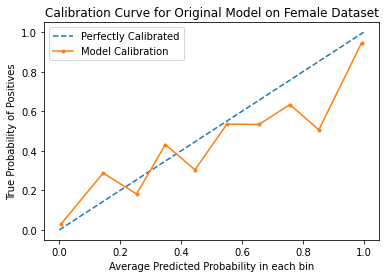

In [ ]:
prob_true, prob_pred = calibration_curve(test_labels, orig_f_pred_probs[:,1], n_bins = 10)

# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfectly Calibrated')
 
# Plot model's calibration curve
plt.plot(prob_pred, prob_true, marker = '.', label = 'Model Calibration')
 
leg = plt.legend(loc = 'upper left')
plt.title('Calibration Curve for Original Model on Female Dataset')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('True Probability of Positives')
plt.show()

#### Neutral Model

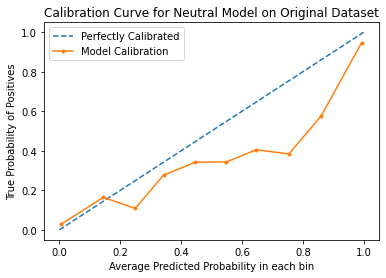

In [ ]:
prob_true, prob_pred = calibration_curve(test_labels, unk_pred_probs[:,1], n_bins = 10)

# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfectly Calibrated')
 
# Plot model's calibration curve
plt.plot(prob_pred, prob_true, marker = '.', label = 'Model Calibration')
 
leg = plt.legend(loc = 'upper left')
plt.title('Calibration Curve for Neutral Model on Original Dataset')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('True Probability of Positives')
plt.show()

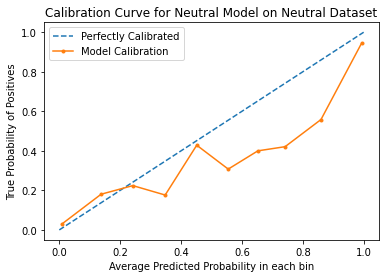

In [ ]:
prob_true, prob_pred = calibration_curve(test_labels, unk_n_pred_probs[:,1], n_bins = 10)

# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfectly Calibrated')
 
# Plot model's calibration curve
plt.plot(prob_pred, prob_true, marker = '.', label = 'Model Calibration')
 
leg = plt.legend(loc = 'upper left')
plt.title('Calibration Curve for Neutral Model on Neutral Dataset')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('True Probability of Positives')
plt.show()

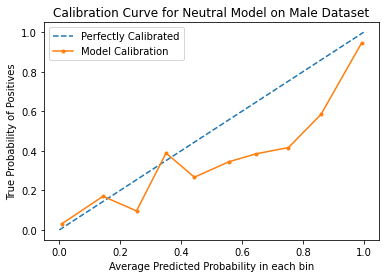

In [ ]:
prob_true, prob_pred = calibration_curve(test_labels, unk_m_pred_probs[:,1], n_bins = 10)

# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfectly Calibrated')
 
# Plot model's calibration curve
plt.plot(prob_pred, prob_true, marker = '.', label = 'Model Calibration')
 
leg = plt.legend(loc = 'upper left')
plt.title('Calibration Curve for Neutral Model on Male Dataset')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('True Probability of Positives')
plt.show()

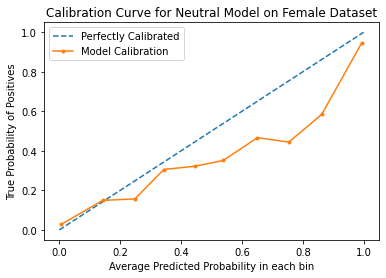

In [ ]:
prob_true, prob_pred = calibration_curve(test_labels, unk_f_pred_probs[:,1], n_bins = 10)

# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfectly Calibrated')
 
# Plot model's calibration curve
plt.plot(prob_pred, prob_true, marker = '.', label = 'Model Calibration')
 
leg = plt.legend(loc = 'upper left')
plt.title('Calibration Curve for Neutral Model on Female Dataset')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('True Probability of Positives')
plt.show()

#### Combined Plots

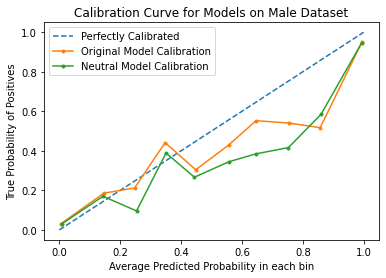

In [ ]:
orig_prob_true, orig_prob_pred = calibration_curve(test_labels, orig_m_pred_probs[:,1], n_bins = 10)
unk_prob_true, unk_prob_pred = calibration_curve(test_labels, unk_m_pred_probs[:,1], n_bins = 10)

# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfectly Calibrated')
 
# Plot original model's calibration curve
plt.plot(orig_prob_pred, orig_prob_true, marker = '.', label = 'Original Model Calibration')

# Plot neutral model's calibration curve
plt.plot(unk_prob_pred, unk_prob_true, marker = '.', label = 'Neutral Model Calibration')
 
leg = plt.legend(loc = 'upper left')
plt.title('Calibration Curve for Models on Male Dataset')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('True Probability of Positives')
plt.show()

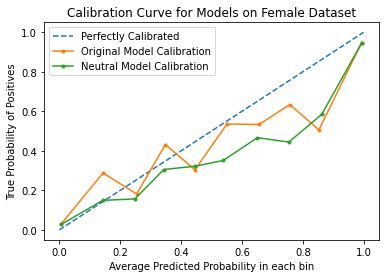

In [ ]:
orig_prob_true, orig_prob_pred = calibration_curve(test_labels, orig_f_pred_probs[:,1], n_bins = 10)
unk_prob_true, unk_prob_pred = calibration_curve(test_labels, unk_f_pred_probs[:,1], n_bins = 10)

# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfectly Calibrated')
 
# Plot original model's calibration curve
plt.plot(orig_prob_pred, orig_prob_true, marker = '.', label = 'Original Model Calibration')

# Plot neutral model's calibration curve
plt.plot(unk_prob_pred, unk_prob_true, marker = '.', label = 'Neutral Model Calibration')
 
leg = plt.legend(loc = 'upper left')
plt.title('Calibration Curve for Models on Female Dataset')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('True Probability of Positives')
plt.show()

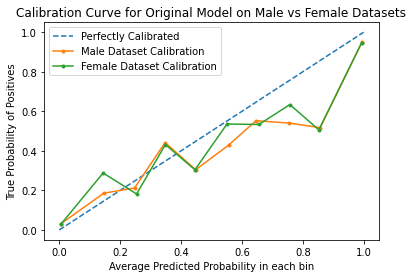

In [ ]:
m_prob_true, m_prob_pred = calibration_curve(test_labels, orig_m_pred_probs[:,1], n_bins = 10)
f_prob_true, f_prob_pred = calibration_curve(test_labels, orig_f_pred_probs[:,1], n_bins = 10)

# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfectly Calibrated')
 
# Plot male dataset calibration curve
plt.plot(m_prob_pred, m_prob_true, marker = '.', label = 'Male Dataset Calibration')

# Plot female dataset calibration curve
plt.plot(f_prob_pred, f_prob_true, marker = '.', label = 'Female Dataset Calibration')
 
leg = plt.legend(loc = 'upper left')
plt.title('Calibration Curve for Original Model on Male vs Female Datasets')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('True Probability of Positives')
plt.show()

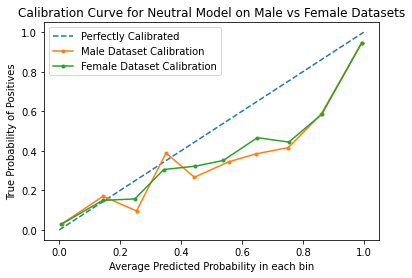

In [ ]:
m_prob_true, m_prob_pred = calibration_curve(test_labels, unk_m_pred_probs[:,1], n_bins = 10)
f_prob_true, f_prob_pred = calibration_curve(test_labels, unk_f_pred_probs[:,1], n_bins = 10)

# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfectly Calibrated')
 
# Plot male dataset calibration curve
plt.plot(m_prob_pred, m_prob_true, marker = '.', label = 'Male Dataset Calibration')

# Plot female dataset calibration curve
plt.plot(f_prob_pred, f_prob_true, marker = '.', label = 'Female Dataset Calibration')
 
leg = plt.legend(loc = 'upper left')
plt.title('Calibration Curve for Neutral Model on Male vs Female Datasets')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('True Probability of Positives')
plt.show()

### Accuracy on Short vs Long Texts

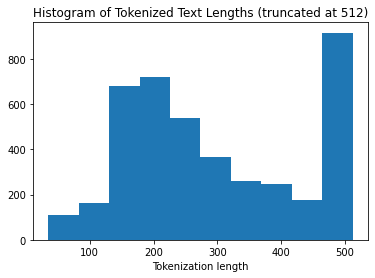

In [ ]:
plt.hist([np.sum(mask) for mask in test_encodings.attention_mask])
plt.title('Histogram of Tokenized Text Lengths (truncated at 512)')
plt.xlabel('Tokenization length')
plt.show()

In [ ]:
def model_scores_against_length(scores, bins, encodings):

  bin_counts = [0]*(len(bins)-1)
  bin_correct = [0]*(len(bins)-1)

  for mask, s in zip(encodings.attention_mask, scores):
    t_len = np.sum(mask)

    for i,bin in enumerate(bins):
      if t_len > int(bin):
        continue
      elif t_len <= int(bin):
        bin_counts[i-1] += 1
        bin_correct[i-1] += s
        break

  return np.array(bin_correct)/np.array(bin_counts)

#### Original Model

[0.92982456 0.94184028 0.93345324 0.93043478 0.92991914 0.89900249]


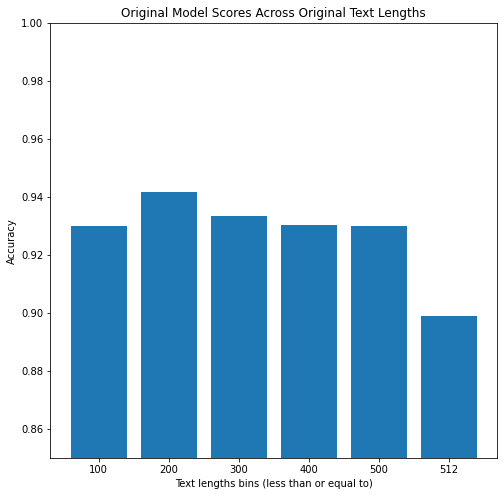

In [ ]:
bins = [str(x) for x in range(0,501, 100)]
bins.append('512')
orig_bin_scores = model_scores_against_length(orig_scores, bins, test_encodings)
print(orig_bin_scores)

plt.figure(figsize=(8,8))
plt.bar(bins[1:], orig_bin_scores)
plt.title("Original Model Scores Across Original Text Lengths")
plt.xlabel("Text lengths bins (less than or equal to)")
plt.ylabel("Accuracy")
plt.ylim(0.85, 1)
plt.show()

[0.93567251 0.9375     0.9352518  0.92869565 0.92722372 0.90024938]


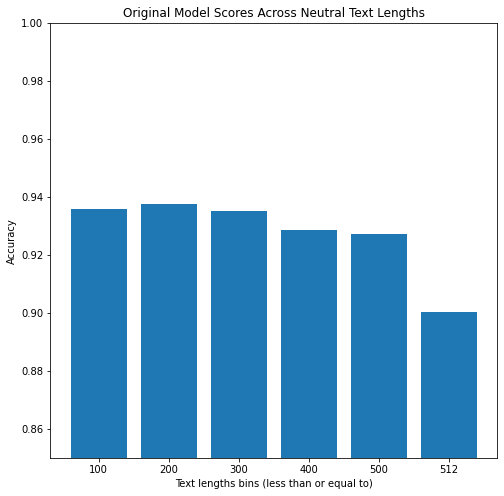

In [ ]:
bins = [str(x) for x in range(0,501, 100)]
bins.append('512')
orig_n_bin_scores = model_scores_against_length(orig_n_scores, bins, n_test_encodings)
print(orig_n_bin_scores)

plt.figure(figsize=(8,8))
plt.bar(bins[1:], orig_n_bin_scores)
plt.title("Original Model Scores Across Neutral Text Lengths")
plt.xlabel("Text lengths bins (less than or equal to)")
plt.ylabel("Accuracy")
plt.ylim(0.85, 1)
plt.show()

[0.92982456 0.94270833 0.93255396 0.93043478 0.92972973 0.89788294]


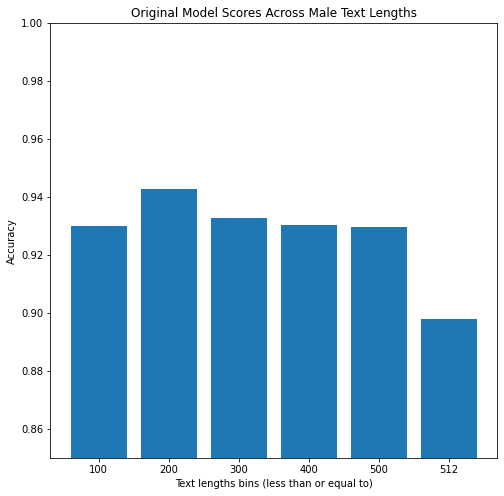

In [ ]:
bins = [str(x) for x in range(0,501, 100)]
bins.append('512')
orig_m_bin_scores = model_scores_against_length(orig_m_scores, bins, m_test_encodings)
print(orig_m_bin_scores)

plt.figure(figsize=(8,8))
plt.bar(bins[1:], orig_m_bin_scores)
plt.title("Original Model Scores Across Male Text Lengths")
plt.xlabel("Text lengths bins (less than or equal to)")
plt.ylabel("Accuracy")
plt.ylim(0.85, 1)
plt.show()

[0.92982456 0.94265856 0.93339334 0.93229167 0.92741935 0.90523691]


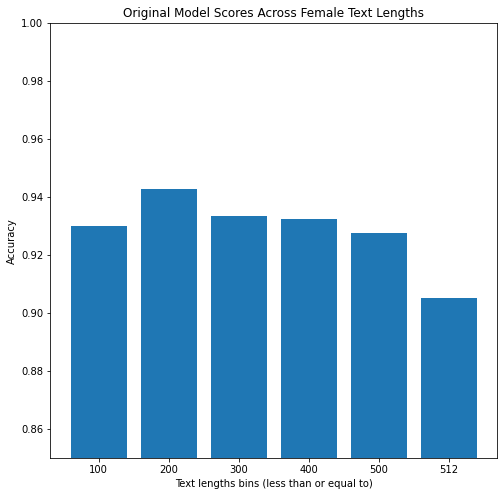

In [ ]:
bins = [str(x) for x in range(0,501, 100)]
bins.append('512')
orig_f_bin_scores = model_scores_against_length(orig_f_scores, bins, f_test_encodings)
print(orig_f_bin_scores)

plt.figure(figsize=(8,8))
plt.bar(bins[1:], orig_f_bin_scores)
plt.title("Original Model Scores Across Female Text Lengths")
plt.xlabel("Text lengths bins (less than or equal to)")
plt.ylabel("Accuracy")
plt.ylim(0.85, 1)
plt.show()

#### Neutral Model

[0.90643275 0.94097222 0.93255396 0.94086957 0.91644205 0.90648379]


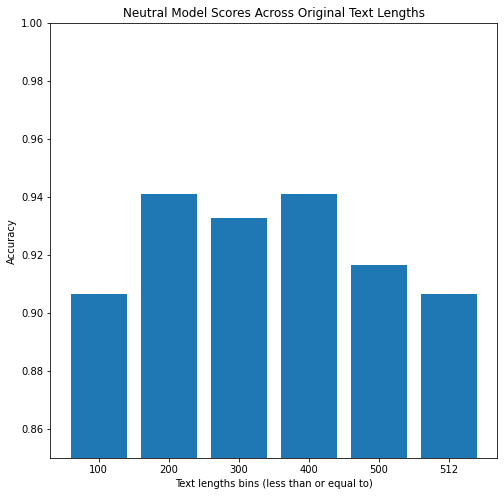

In [ ]:
bins = [str(x) for x in range(0,501, 100)]
bins.append('512')
unk_bin_scores = model_scores_against_length(unk_scores, bins, test_encodings)
print(unk_bin_scores)

plt.figure(figsize=(8,8))
plt.bar(bins[1:], unk_bin_scores)
plt.title("Neutral Model Scores Across Original Text Lengths")
plt.xlabel("Text lengths bins (less than or equal to)")
plt.ylabel("Accuracy")
plt.ylim(0.85, 1)
plt.show()

[0.90643275 0.94097222 0.9307554  0.9426087  0.9083558  0.90773067]


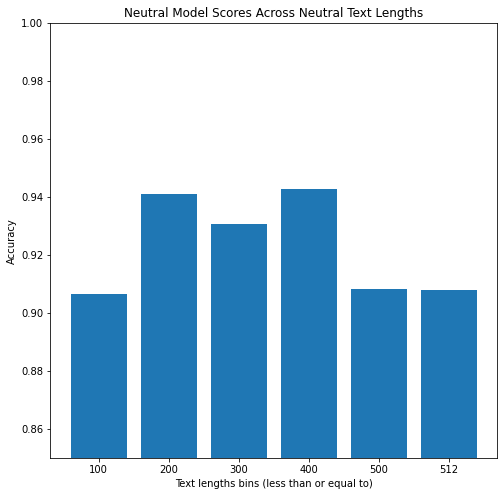

In [ ]:
bins = [str(x) for x in range(0,501, 100)]
bins.append('512')
unk_n_bin_scores = model_scores_against_length(unk_n_scores, bins, n_test_encodings)
print(unk_n_bin_scores)

plt.figure(figsize=(8,8))
plt.bar(bins[1:], unk_n_bin_scores)
plt.title("Neutral Model Scores Across Neutral Text Lengths")
plt.xlabel("Text lengths bins (less than or equal to)")
plt.ylabel("Accuracy")
plt.ylim(0.85, 1)
plt.show()

[0.90643275 0.94184028 0.93165468 0.93913043 0.91891892 0.90660025]


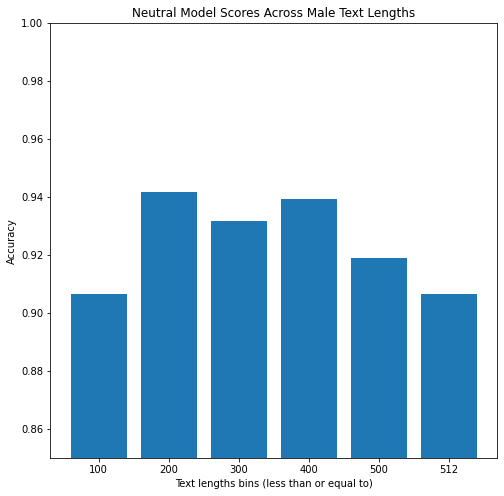

In [ ]:
bins = [str(x) for x in range(0,501, 100)]
bins.append('512')
unk_m_bin_scores = model_scores_against_length(unk_m_scores, bins, m_test_encodings)
print(unk_m_bin_scores)

plt.figure(figsize=(8,8))
plt.bar(bins[1:], unk_m_bin_scores)
plt.title("Neutral Model Scores Across Male Text Lengths")
plt.xlabel("Text lengths bins (less than or equal to)")
plt.ylabel("Accuracy")
plt.ylim(0.85, 1)
plt.show()

[0.90643275 0.94178975 0.93069307 0.94097222 0.91666667 0.90897756]


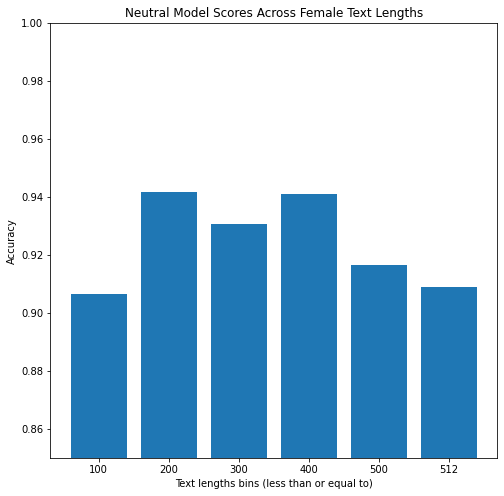

In [ ]:
bins = [str(x) for x in range(0,501, 100)]
bins.append('512')
unk_f_bin_scores = model_scores_against_length(unk_f_scores, bins, f_test_encodings)
print(unk_f_bin_scores)

plt.figure(figsize=(8,8))
plt.bar(bins[1:], unk_f_bin_scores)
plt.title("Neutral Model Scores Across Female Text Lengths")
plt.xlabel("Text lengths bins (less than or equal to)")
plt.ylabel("Accuracy")
plt.ylim(0.85, 1)
plt.show()

#### Combined Plots

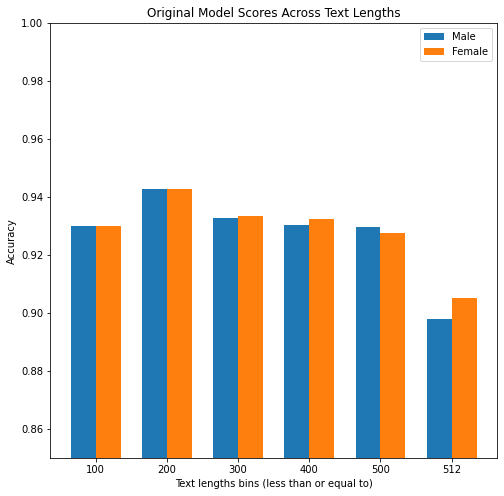

In [ ]:
bins = [str(x) for x in range(0,501, 100)]
bins.append('512')

x = np.arange(len(bins[1:]))
width = 0.35 

plt.figure(figsize=(8,8))
plt.bar(x - width/2, orig_m_bin_scores, width, label='Male')
plt.bar(x + width/2,  orig_f_bin_scores, width, label='Female')
plt.legend()

plt.title("Original Model Scores Across Text Lengths")
plt.xlabel("Text lengths bins (less than or equal to)")
plt.ylabel("Accuracy")
plt.ylim(0.85, 1)
plt.xticks(x, bins[1:])
plt.show()

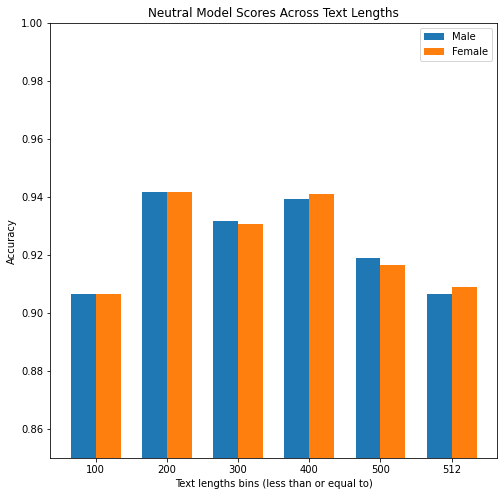

In [ ]:
bins = [str(x) for x in range(0,501, 100)]
bins.append('512')

x = np.arange(len(bins[1:]))
width = 0.35 

plt.figure(figsize=(8,8))
plt.bar(x - width/2, unk_m_bin_scores, width, label='Male')
plt.bar(x + width/2,  unk_f_bin_scores, width, label='Female')
plt.legend()

plt.title("Neutral Model Scores Across Text Lengths")
plt.xlabel("Text lengths bins (less than or equal to)")
plt.ylabel("Accuracy")
plt.ylim(0.85, 1)
plt.xticks(x, bins[1:])
plt.show()

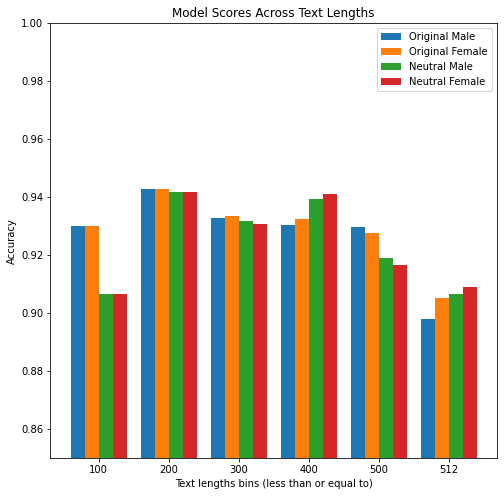

In [ ]:
bins = [str(x) for x in range(0,501, 100)]
bins.append('512')

x = np.arange(len(bins[1:]))
width = 0.2

plt.figure(figsize=(8,8))
plt.bar(x - 3*width/2, orig_m_bin_scores, width, label='Original Male')
plt.bar(x - width/2,  orig_f_bin_scores, width, label='Original Female')
plt.bar(x + width/2, unk_m_bin_scores, width, label='Neutral Male')
plt.bar(x + 3*width/2,  unk_f_bin_scores, width, label='Neutral Female')
plt.legend()

plt.title("Model Scores Across Text Lengths")
plt.xlabel("Text lengths bins (less than or equal to)")
plt.ylabel("Accuracy")
plt.ylim(0.85, 1)
plt.xticks(x, bins[1:])
plt.show()

### Errors Across Number of Tokens Replaced

In [300]:
_, split_test_df = train_test_split(df_test, test_size=.5, random_state=seed)

In [301]:
split_test_df

,review_id,review_score,review_text,neutral_review_text,neutral_sub_count,female_review_text,female_sub_count,male_review_text,male_sub_count,label
2412,12199,1,"Acting 10, Script 1. ""Hurlyburly"" is from that...","acting 10, script 1. ""hurlyburly"" is from that...",3,"acting 10, script 1. ""hurlyburly"" is from that...",3,"acting 10, script 1. ""hurlyburly"" is from that...",0,0
6830,10645,4,I'd never seen a Tarzan movie before so when I...,i'd never seen a tarzan movie before so when i...,3,i'd never seen a tarzan movie before so when i...,3,i'd never seen a tarzan movie before so when i...,0,0
5054,8982,8,"Damn, was that a lot to take in. I was pretty ...","damn, was that a lot to take in. i was pretty ...",1,"damn, was that a lot to take in. i was pretty ...",1,"damn, was that a lot to take in. i was pretty ...",0,1
5787,6576,8,Comedies often have the unfortunate reputation...,comedies often have the unfortunate reputation...,15,comedies often have the unfortunate reputation...,9,comedies often have the unfortunate reputation...,6,1
6630,12101,4,"I saw it, I agree with him 100%, but I didn't ...","i saw it, i agree with [UNK] 100%, but i didn'...",11,"i saw it, i agree with her 100%, but i didn't ...",10,"i saw it, i agree with him 100%, but i didn't ...",1,0
...,...,...,...,...,...,...,...,...,...,...
3613,5611,1,This movie had so much potential to be hilario...,this movie had so much potential to be hilario...,6,this movie had so much potential to be hilario...,5,this movie had so much potential to be hilario...,1,0
305,6888,10,I absolutely love Promised Land. The first epi...,i absolutely love promised land. the first epi...,1,i absolutely love promised land. the first epi...,1,i absolutely love promised land. the first epi...,0,1
1849,6145,8,"I, as many IMDB patrons seem to have, stumbled...","i, as many imdb patrons seem to have, stumbled...",1,"i, as many imdb patrons seem to have, stumbled...",1,"i, as many imdb patrons seem to have, stumbled...",0,1
6906,3909,2,When I found out there was a movie that had bo...,when i found out there was a movie that had bo...,7,when i found out there was a movie that had bo...,4,when i found out there was a movie that had bo...,3,0


In [34]:
# Check that split df is equal to split texts
print(split_test_df['review_text'].values.tolist() == test_texts)
print(split_test_df['neutral_review_text'].values.tolist() == n_test_texts)
print(split_test_df['female_review_text'].values.tolist() == f_test_texts)
print(split_test_df['male_review_text'].values.tolist() == m_test_texts)

True
True
True
True


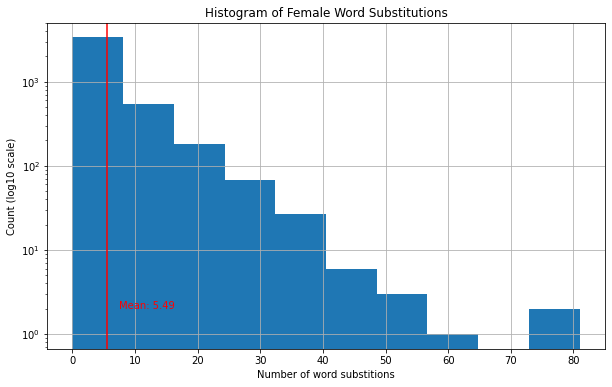

In [ ]:
plt.figure(figsize=(10,6))
split_test_df['female_sub_count'].hist()
f_mean = np.mean(split_test_df['female_sub_count'])

plt.title("Histogram of Female Word Substitutions")
plt.xlabel("Number of word substitions")
plt.axvline(f_mean, color='r')
plt.annotate(f'Mean: {f_mean:.2f}', (f_mean+2, 2), color='r')
plt.ylabel("Count (log10 scale)")
plt.yscale('log')
plt.show()

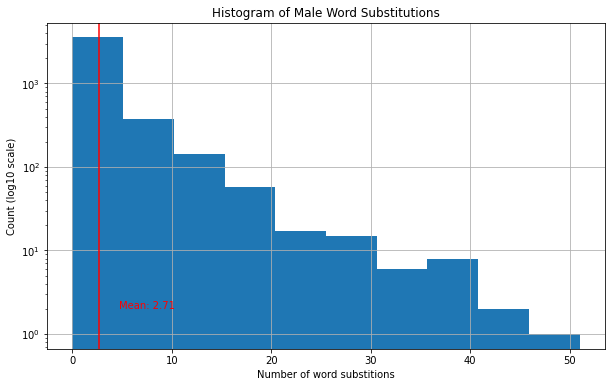

In [ ]:
plt.figure(figsize=(10,6))
split_test_df['male_sub_count'].hist()
m_mean = np.mean(split_test_df['male_sub_count'])

plt.title("Histogram of Male Word Substitutions")
plt.xlabel("Number of word substitions")
plt.axvline(m_mean, color='r')
plt.annotate(f'Mean: {m_mean:.2f}', (m_mean+2, 2), color='r')
plt.ylabel("Count (log10 scale)")
plt.yscale('log')
plt.show()

In [ ]:
def errors_across_replacements(scores, reps):

  reps_error_count = {}

  for score, rep in zip(scores, reps):
    if score == 0:
      reps_error_count[rep] = reps_error_count.get(rep, 0) + 1

  return reps_error_count

In [ ]:
def pct_errors_across_replacements(scores, reps):

  reps_count = {}
  reps_error_count = {}
  reps_pct_errors = {}

  for score, rep in zip(scores, reps):
    reps_count[rep] = reps_count.get(rep, 0) + 1

    if score == 0:
      reps_error_count[rep] = reps_error_count.get(rep, 0) + 1

  for k in reps_error_count.keys():
    reps_pct_errors[k] = 1 - reps_error_count[k]/reps_count[k]
      
  return reps_pct_errors


#### Original Model

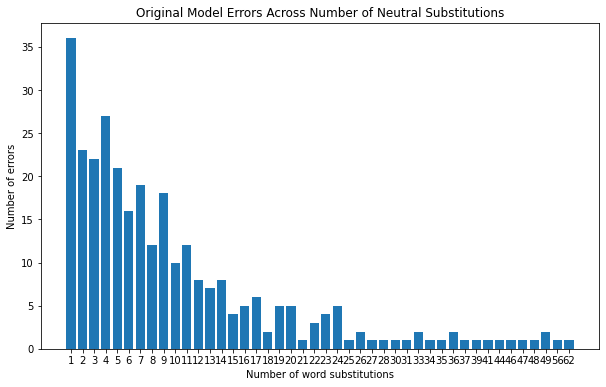

In [ ]:
n_reps = split_test_df['neutral_sub_count'].values.tolist()
n_reps_errors = errors_across_replacements(orig_n_scores, n_reps)

x = [str(k) for k,v in sorted(n_reps_errors.items())]
y = [v for k,v in sorted(n_reps_errors.items())]

plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title('Original Model Errors Across Number of Neutral Substitutions')
plt.xlabel("Number of word substitutions")
plt.ylabel("Number of errors")
plt.show()

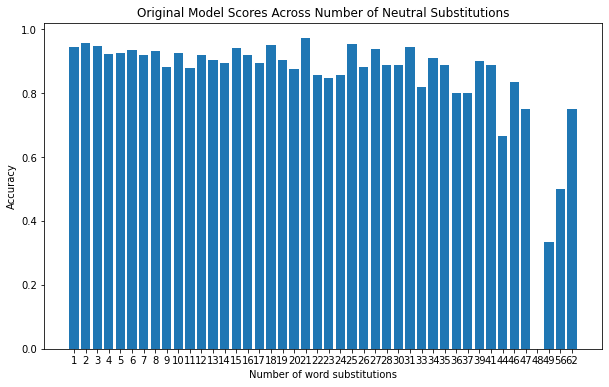

In [ ]:
n_reps = split_test_df['neutral_sub_count'].values.tolist()
n_reps_errors = pct_errors_across_replacements(orig_n_scores, n_reps)

x = [str(k) for k,v in sorted(n_reps_errors.items())]
y = [v for k,v in sorted(n_reps_errors.items())]

plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title('Original Model Scores Across Number of Neutral Substitutions')
plt.xlabel("Number of word substitutions")
plt.ylabel("Accuracy")
plt.show()

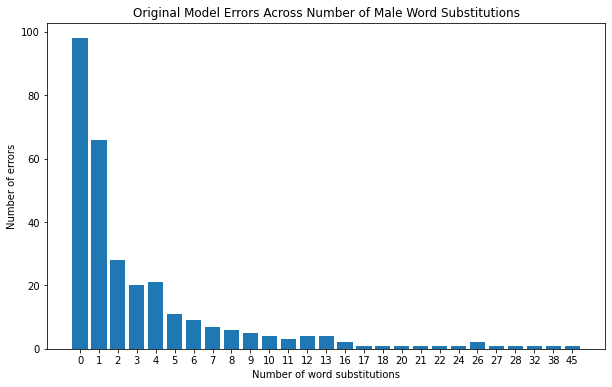

In [ ]:
m_reps = split_test_df['male_sub_count'].values.tolist()
m_reps_errors = errors_across_replacements(orig_m_scores, m_reps)

x = [str(k) for k,v in sorted(m_reps_errors.items())]
y = [v for k,v in sorted(m_reps_errors.items())]

plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title('Original Model Errors Across Number of Male Word Substitutions')
plt.xlabel("Number of word substitutions")
plt.ylabel("Number of errors")
plt.show()

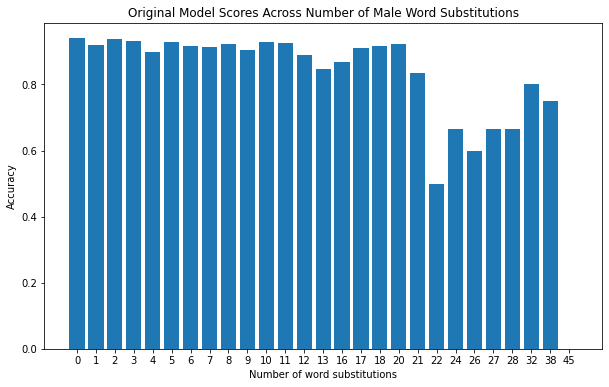

In [ ]:
m_reps = split_test_df['male_sub_count'].values.tolist()
m_reps_errors = pct_errors_across_replacements(orig_m_scores, m_reps)

x = [str(k) for k,v in sorted(m_reps_errors.items())]
y = [v for k,v in sorted(m_reps_errors.items())]

plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title('Original Model Scores Across Number of Male Word Substitutions')
plt.xlabel("Number of word substitutions")
plt.ylabel("Accuracy")
plt.show()

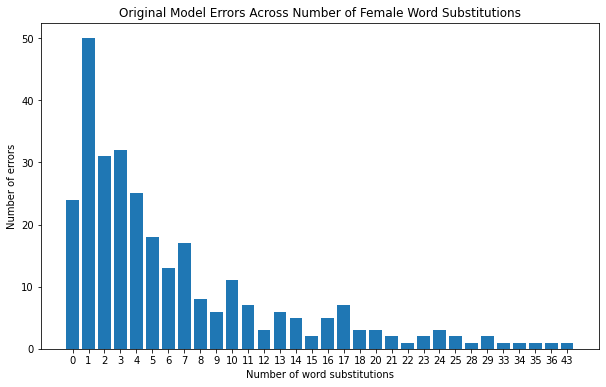

In [ ]:
f_reps = split_test_df['female_sub_count'].values.tolist()
f_reps_errors = errors_across_replacements(orig_f_scores, f_reps)

x = [str(k) for k,v in sorted(f_reps_errors.items())]
y = [v for k,v in sorted(f_reps_errors.items())]

plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title('Original Model Errors Across Number of Female Word Substitutions')
plt.xlabel("Number of word substitutions")
plt.ylabel("Number of errors")
plt.show()

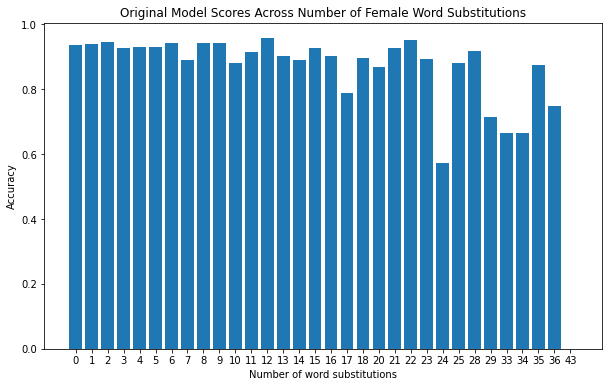

In [ ]:
f_reps = split_test_df['female_sub_count'].values.tolist()
f_reps_errors = pct_errors_across_replacements(orig_f_scores, f_reps)

x = [str(k) for k,v in sorted(f_reps_errors.items())]
y = [v for k,v in sorted(f_reps_errors.items())]

plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title('Original Model Scores Across Number of Female Word Substitutions')
plt.xlabel("Number of word substitutions")
plt.ylabel("Accuracy")
plt.show()

#### Neutral Model

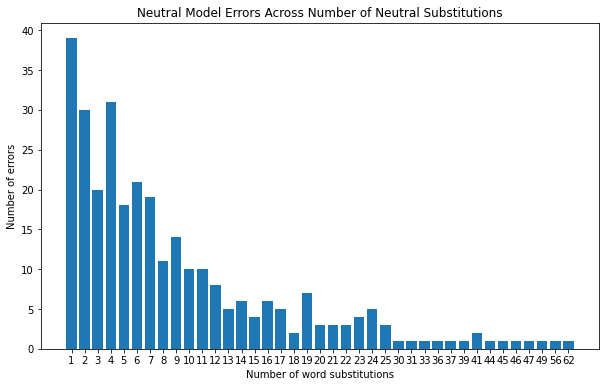

In [ ]:
n_reps = split_test_df['neutral_sub_count'].values.tolist()
n_reps_errors = errors_across_replacements(unk_n_scores, n_reps)

x = [str(k) for k,v in sorted(n_reps_errors.items())]
y = [v for k,v in sorted(n_reps_errors.items())]

plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title('Neutral Model Errors Across Number of Neutral Substitutions')
plt.xlabel("Number of word substitutions")
plt.ylabel("Number of errors")
plt.show()

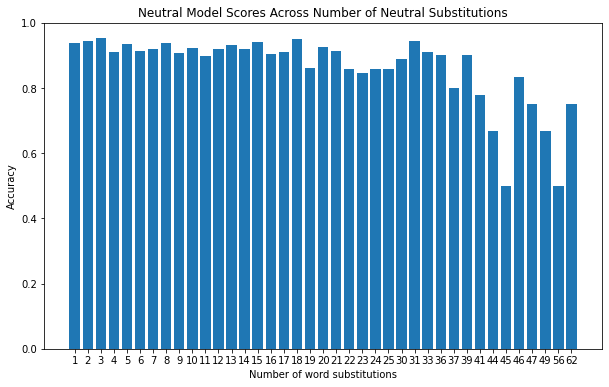

In [ ]:
n_reps = split_test_df['neutral_sub_count'].values.tolist()
n_reps_errors = pct_errors_across_replacements(unk_n_scores, n_reps)

x = [str(k) for k,v in sorted(n_reps_errors.items())]
y = [v for k,v in sorted(n_reps_errors.items())]

plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title('Neutral Model Scores Across Number of Neutral Substitutions')
plt.xlabel("Number of word substitutions")
plt.ylabel("Accuracy")
plt.show()

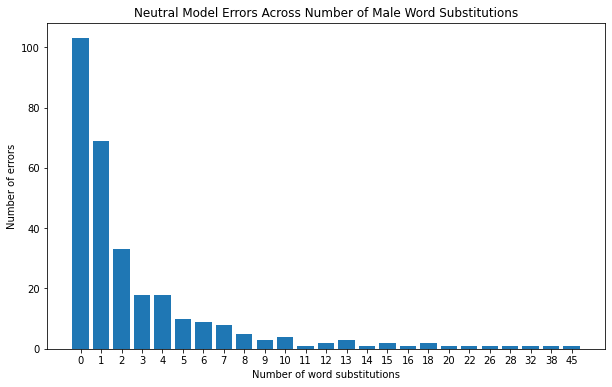

In [ ]:
m_reps = split_test_df['male_sub_count'].values.tolist()
m_reps_errors = errors_across_replacements(unk_m_scores, m_reps)

x = [str(k) for k,v in sorted(m_reps_errors.items())]
y = [v for k,v in sorted(m_reps_errors.items())]

plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title('Neutral Model Errors Across Number of Male Word Substitutions')
plt.xlabel("Number of word substitutions")
plt.ylabel("Number of errors")
plt.show()

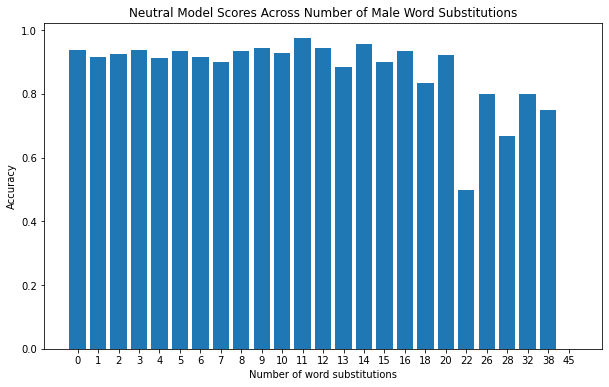

In [ ]:
m_reps = split_test_df['male_sub_count'].values.tolist()
m_reps_errors = pct_errors_across_replacements(unk_m_scores, m_reps)

x = [str(k) for k,v in sorted(m_reps_errors.items())]
y = [v for k,v in sorted(m_reps_errors.items())]

plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title('Neutral Model Scores Across Number of Male Word Substitutions')
plt.xlabel("Number of word substitutions")
plt.ylabel("Accuracy")
plt.show()

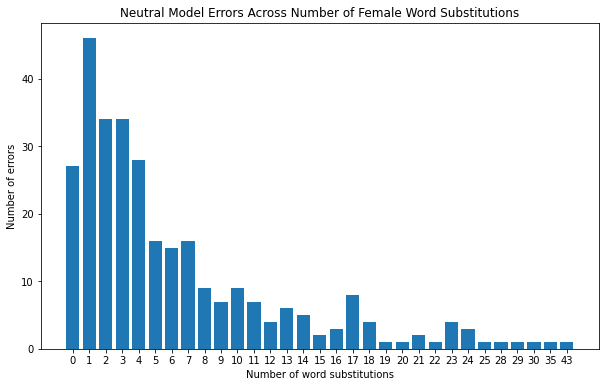

In [ ]:
f_reps = split_test_df['female_sub_count'].values.tolist()
f_reps_errors = errors_across_replacements(unk_f_scores, f_reps)

x = [str(k) for k,v in sorted(f_reps_errors.items())]
y = [v for k,v in sorted(f_reps_errors.items())]

plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title('Neutral Model Errors Across Number of Female Word Substitutions')
plt.xlabel("Number of word substitutions")
plt.ylabel("Number of errors")
plt.show()

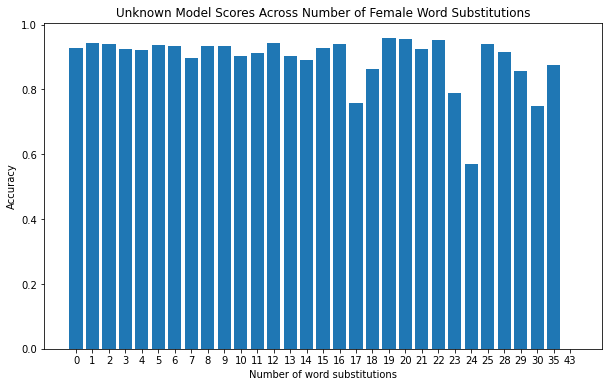

In [ ]:
f_reps = split_test_df['female_sub_count'].values.tolist()
f_reps_errors = pct_errors_across_replacements(unk_f_scores, f_reps)

x = [str(k) for k,v in sorted(f_reps_errors.items())]
y = [v for k,v in sorted(f_reps_errors.items())]

plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title('Unknown Model Scores Across Number of Female Word Substitutions')
plt.xlabel("Number of word substitutions")
plt.ylabel("Accuracy")
plt.show()

### Errors Across Proportion of Tokens Replaced

[ 1.93423598  3.87096774  1.5015015  ...  0.6377551   7.54310345
 11.00412655]


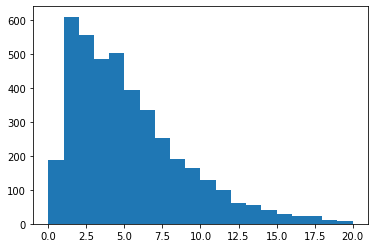

In [39]:
n_sub_counts = split_test_df['neutral_sub_count'].values
n_review_lens = np.array([len(review) for review in split_test_df['neutral_review_text']])
n_rep_props = (n_sub_counts/n_review_lens)*1000
print(n_rep_props)
plt.hist(n_rep_props, bins=list(range(0,21, 1)))
plt.show()

In [48]:
def pct_errors_across_replacement_bins(scores, sub_counts, review_lens, bins):

  props = (sub_counts/review_lens)*1000

  bins_error_count = {}
  bins_count = {}
  bins_pct_errors = {}

  for score, prop in zip(scores, props):
    for bin in bins:
      if prop >= bin:
        continue
      else:
        bins_count[bin] = bins_count.get(bin, 0) + 1
        if score == 0:
          bins_error_count[bin] = bins_error_count.get(bin, 0) + 1
        break

  for k in bins_error_count.keys():
    bins_pct_errors[k] = 1 - bins_error_count[k]/bins_count[k]

  return bins_pct_errors

#### Original Model

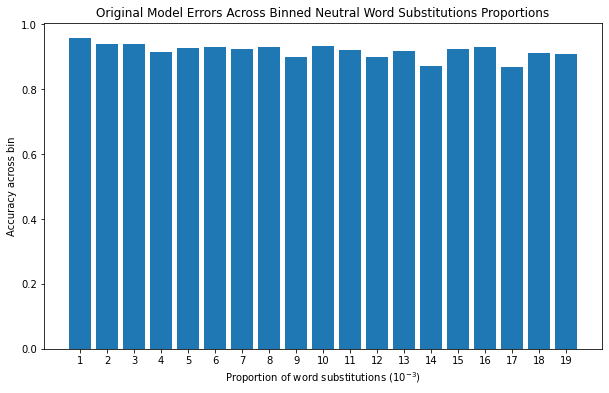

In [80]:
bins=list(range(0,21, 1))
n_sub_counts = split_test_df['neutral_sub_count'].values
n_review_lens = np.array([len(review) for review in split_test_df['neutral_review_text']])
n_reps_bins_errors = pct_errors_across_replacement_bins(orig_n_scores, n_sub_counts, n_review_lens, bins)

x = [str(k) for k,v in sorted(n_reps_bins_errors.items())]
y = [v for k,v in sorted(n_reps_bins_errors.items())]

plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title('Original Model Errors Across Binned Neutral Word Substitutions Proportions')
plt.xlabel(r"Proportion of word substitutions ($10^{-3}$)")
plt.ylabel("Accuracy across bin")
plt.show()

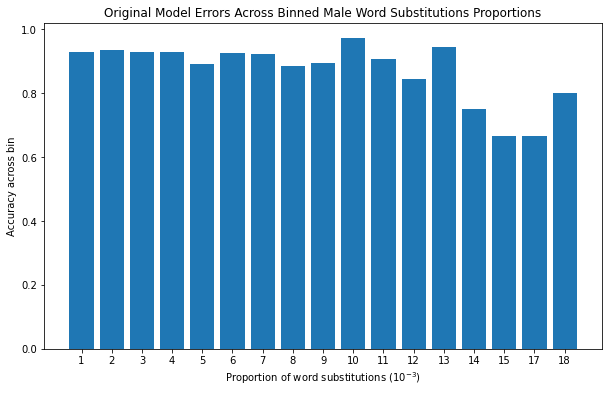

In [81]:
bins=list(range(0,21, 1))
m_sub_counts = split_test_df['male_sub_count'].values
m_review_lens = np.array([len(review) for review in split_test_df['male_review_text']])
m_reps_bins_errors = pct_errors_across_replacement_bins(orig_m_scores, m_sub_counts, m_review_lens, bins)

x = [str(k) for k,v in sorted(m_reps_bins_errors.items())]
y = [v for k,v in sorted(m_reps_bins_errors.items())]

plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title('Original Model Errors Across Binned Male Word Substitutions Proportions')
plt.xlabel(r"Proportion of word substitutions ($10^{-3}$)")
plt.ylabel("Accuracy across bin")
plt.show()

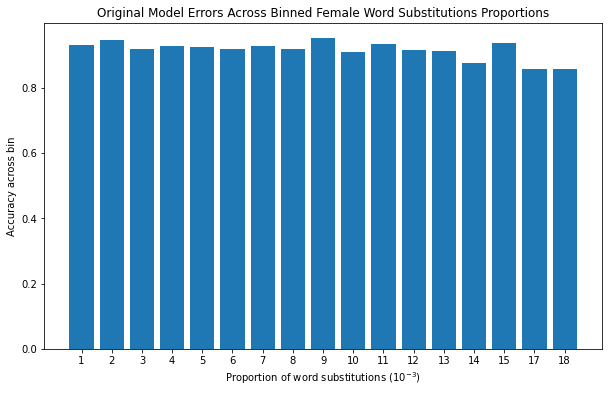

In [82]:
bins=list(range(0,21, 1))
f_sub_counts = split_test_df['female_sub_count'].values
f_review_lens = np.array([len(review) for review in split_test_df['female_review_text']])
f_reps_bins_errors = pct_errors_across_replacement_bins(orig_f_scores, f_sub_counts, f_review_lens, bins)

x = [str(k) for k,v in sorted(f_reps_bins_errors.items())]
y = [v for k,v in sorted(f_reps_bins_errors.items())]

plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title('Original Model Errors Across Binned Female Word Substitutions Proportions')
plt.xlabel(r"Proportion of word substitutions ($10^{-3}$)")
plt.ylabel("Accuracy across bin")
plt.show()

#### Neutral Model

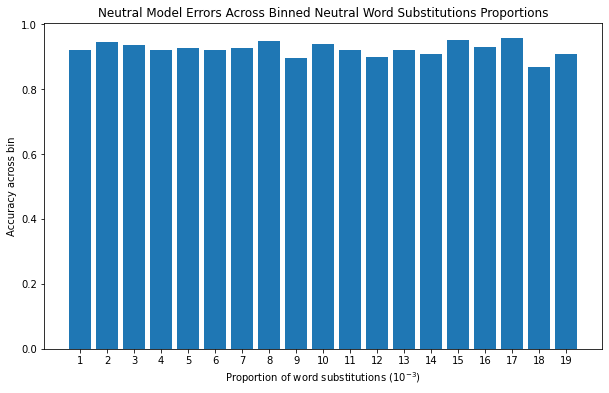

In [83]:
bins=list(range(0,21, 1))
n_sub_counts = split_test_df['neutral_sub_count'].values
n_review_lens = np.array([len(review) for review in split_test_df['neutral_review_text']])
n_reps_bins_errors = pct_errors_across_replacement_bins(unk_n_scores, n_sub_counts, n_review_lens, bins)

x = [str(k) for k,v in sorted(n_reps_bins_errors.items())]
y = [v for k,v in sorted(n_reps_bins_errors.items())]

plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title('Neutral Model Errors Across Binned Neutral Word Substitutions Proportions')
plt.xlabel(r"Proportion of word substitutions ($10^{-3}$)")
plt.ylabel("Accuracy across bin")
plt.show()

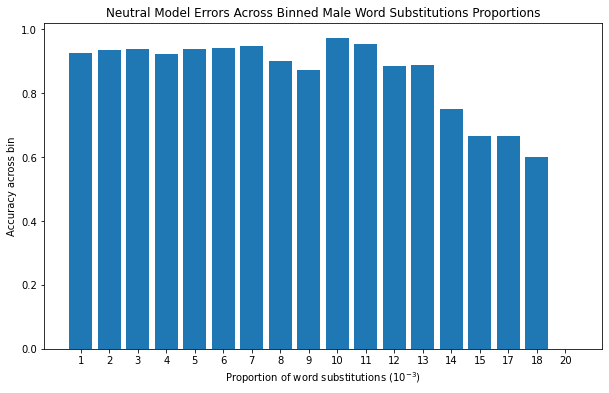

In [84]:
bins=list(range(0,21, 1))
m_sub_counts = split_test_df['male_sub_count'].values
m_review_lens = np.array([len(review) for review in split_test_df['male_review_text']])
m_reps_bins_errors = pct_errors_across_replacement_bins(unk_m_scores, m_sub_counts, m_review_lens, bins)

x = [str(k) for k,v in sorted(m_reps_bins_errors.items())]
y = [v for k,v in sorted(m_reps_bins_errors.items())]

plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title('Neutral Model Errors Across Binned Male Word Substitutions Proportions')
plt.xlabel(r"Proportion of word substitutions ($10^{-3}$)")
plt.ylabel("Accuracy across bin")
plt.show()

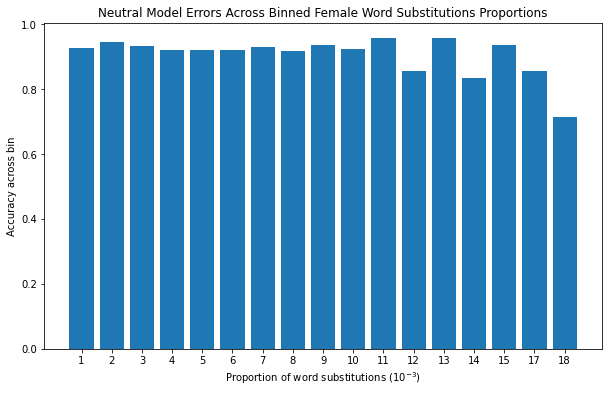

In [85]:
bins=list(range(0,21, 1))
f_sub_counts = split_test_df['female_sub_count'].values
f_review_lens = np.array([len(review) for review in split_test_df['female_review_text']])
f_reps_bins_errors = pct_errors_across_replacement_bins(unk_f_scores, f_sub_counts, f_review_lens, bins)

x = [str(k) for k,v in sorted(f_reps_bins_errors.items())]
y = [v for k,v in sorted(f_reps_bins_errors.items())]

plt.figure(figsize=(10,6))
plt.bar(x, y)
plt.title('Neutral Model Errors Across Binned Female Word Substitutions Proportions')
plt.xlabel(r"Proportion of word substitutions ($10^{-3}$)")
plt.ylabel("Accuracy across bin")
plt.show()

#### Combine Plots

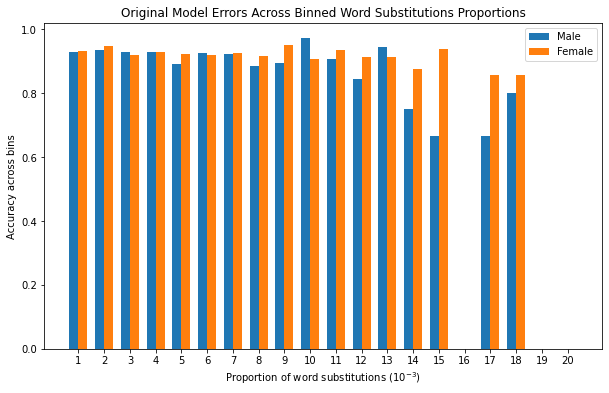

In [87]:
bins=list(range(0,21, 1))
error_calcs = [(orig_m_scores, m_sub_counts, m_review_lens), 
               (orig_f_scores, f_sub_counts, f_review_lens)]
labels = ['Male', 'Female']

width = 0.35 
x_ticks = np.arange(len(bins[1:]))
x = x_ticks - width/2

plt.figure(figsize=(10,6))

for (scores, counts, lens), label in zip(error_calcs, labels):
  reps_bins_errors = pct_errors_across_replacement_bins(scores, counts, lens, bins)

  y = [0]*len(x)
  for k,v in sorted(reps_bins_errors.items()):
    y[k-1] = v

  plt.bar(x, y, width, label=label)
  x += width

plt.title('Original Model Errors Across Binned Word Substitutions Proportions')
plt.xlabel(r"Proportion of word substitutions ($10^{-3}$)")
plt.ylabel("Accuracy across bins")
plt.xticks(x_ticks, bins[1:])
plt.legend()
plt.show()

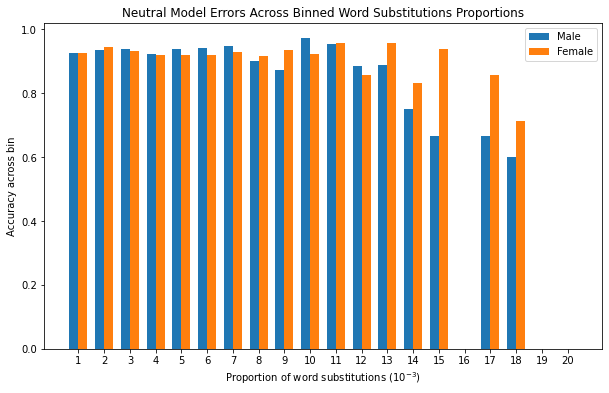

In [88]:
bins=list(range(0,21, 1))
error_calcs = [(unk_m_scores, m_sub_counts, m_review_lens), 
               (unk_f_scores, f_sub_counts, f_review_lens)]
labels = ['Male', 'Female']

width = 0.35 
x_ticks = np.arange(len(bins[1:]))
x = x_ticks - width/2

plt.figure(figsize=(10,6))

for (scores, counts, lens), label in zip(error_calcs, labels):
  reps_bins_errors = pct_errors_across_replacement_bins(scores, counts, lens, bins)

  y = [0]*len(x)
  for k,v in sorted(reps_bins_errors.items()):
    y[k-1] = v

  plt.bar(x, y, width, label=label)
  x += width

plt.title('Neutral Model Errors Across Binned Word Substitutions Proportions')
plt.xlabel(r"Proportion of word substitutions ($10^{-3}$)")
plt.ylabel("Accuracy across bin")
plt.xticks(x_ticks, bins[1:])
plt.legend()
plt.show()

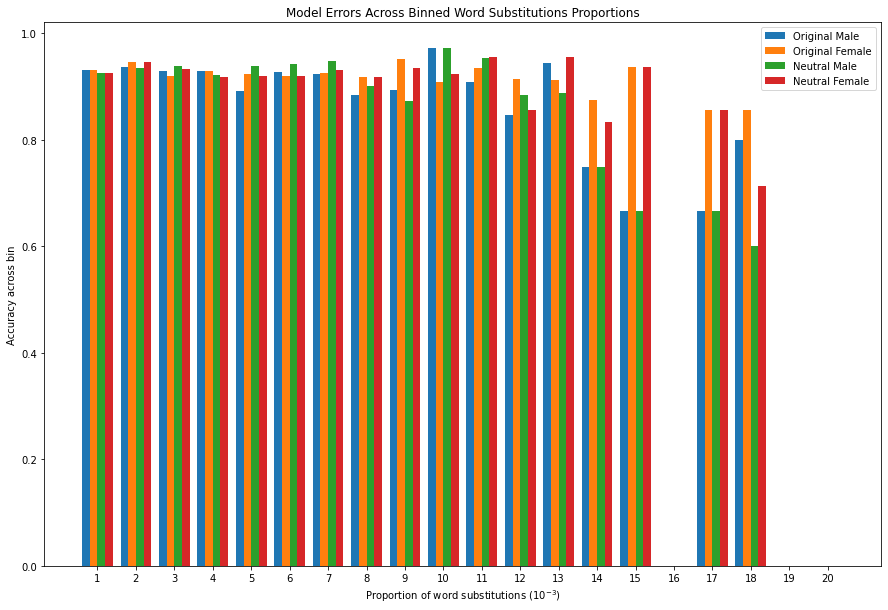

In [89]:
bins=list(range(0,21, 1))
error_calcs = [(orig_m_scores, m_sub_counts, m_review_lens), 
               (orig_f_scores, f_sub_counts, f_review_lens),
               (unk_m_scores, m_sub_counts, m_review_lens),
               (unk_f_scores, f_sub_counts, f_review_lens)]
labels = ['Original Male', 'Original Female', "Neutral Male", "Neutral Female"]

width = 0.2
x_ticks = np.arange(len(bins[1:]))
x = x_ticks - 3*width/2

plt.figure(figsize=(15,10))

for (scores, counts, lens), label in zip(error_calcs, labels):
  reps_bins_errors = pct_errors_across_replacement_bins(scores, counts, lens, bins)

  y = [0]*len(x)
  for k,v in sorted(reps_bins_errors.items()):
    y[k-1] = v

  plt.bar(x, y, width, label=label)
  x += width

plt.title('Model Errors Across Binned Word Substitutions Proportions')
plt.xlabel(r"Proportion of word substitutions ($10^{-3}$)")
plt.ylabel("Accuracy across bin")
plt.xticks(x_ticks, bins[1:])
plt.legend()
plt.show()

### Different Errors Across Original and Neutral Models

In [408]:
m_unq_err_orig = set(orig_m_errors) - set(unk_m_errors)
f_unq_err_orig = set(orig_f_errors) - set(unk_f_errors)
m_unq_err_unk = set(unk_m_errors) - set(orig_m_errors)
f_unq_err_unk = set(unk_f_errors) - set(orig_f_errors)

m_only_unq_err_orig = set(m_unq_err_orig) - set(f_unq_err_orig)
f_only_unq_err_orig = set(f_unq_err_orig) - set(m_unq_err_orig)
m_only_unq_err_unk = set(m_unq_err_unk) - set(f_unq_err_unk)
f_only_unq_err_unk = set(f_unq_err_unk) - set(m_unq_err_unk)

print("Unique male dataset errors from Original model:", len(m_unq_err_orig))
print("Unique female dataset errors from Original model:", len(f_unq_err_orig))
print("Unique male dataset errors from Neutral model:", len(m_unq_err_unk))
print("Unique female dataset errors from Neutral model:", len(f_unq_err_unk))

print()

print("Unique errors from the Original model made on the Male dataset BUT NOT the Female dataset:", len(m_only_unq_err_orig))
print("Unique errors from the Original model made on the Female dataset BUT NOT the Male dataset:", len(f_only_unq_err_orig))
print("Unique errors from the Neutral model made on the Male dataset BUT NOT the Female dataset:", len(m_only_unq_err_unk))
print("Unique errors from the Neutral model made on the Feale dataset BUT NOT the Male dataset:", len(f_only_unq_err_unk))

Unique male dataset errors from Original model: 77
Unique female dataset errors from Original model: 75
Unique male dataset errors from Neutral model: 75
Unique female dataset errors from Neutral model: 79

Unique errors from the Original model made on the Male dataset BUT NOT the Female dataset: 7
Unique errors from the Original model made on the Female dataset BUT NOT the Male dataset: 5
Unique errors from the Neutral model made on the Male dataset BUT NOT the Female dataset: 4
Unique errors from the Neutral model made on the Feale dataset BUT NOT the Male dataset: 8


In [303]:
m_unq_err_orig_df = split_test_df.reset_index(drop=True).loc[m_unq_err_orig]
f_unq_err_orig_df = split_test_df.reset_index(drop=True).loc[f_unq_err_orig]
m_unq_err_unk_df = split_test_df.reset_index(drop=True).loc[m_unq_err_unk]
f_unq_err_unk_df = split_test_df.reset_index(drop=True).loc[f_unq_err_unk]

m_only_unq_err_orig_df = split_test_df.reset_index(drop=True).loc[m_only_unq_err_orig]
f_only_unq_err_orig_df = split_test_df.reset_index(drop=True).loc[f_only_unq_err_orig]
m_only_unq_err_unk_df = split_test_df.reset_index(drop=True).loc[m_only_unq_err_unk]
f_only_unq_err_unk_df = split_test_df.reset_index(drop=True).loc[f_only_unq_err_unk]

#### Original Model

##### Unique Original Model Errors on Male Dataset

In [304]:
texts = m_unq_err_orig_df['review_text'].values.tolist()
review_scores = m_unq_err_orig_df['review_score'].values.tolist()
ids = m_unq_err_orig_df['review_id'].values.tolist()
subs = m_unq_err_orig_df['neutral_sub_count'].values.tolist()
gender_subs =  m_unq_err_orig_df['male_sub_count'].values.tolist()

for id, text, sc, sub, g_sub in zip(ids, texts, review_scores, subs, gender_subs):
  prev_count = 0
  line_count = 100
  if len(text) <= 1000:
    print("Review ID:", id)
    while line_count <= 1000:
      print(text[prev_count:line_count])
      prev_count += 100
      line_count += 100
    print("Review score:", sc)
    print("Male sub count:", g_sub)
    print("Total sub count:", sub)
    print()

Review ID: 5032
This movie was in a sci-fi 50-pack a friend of mine got me for Christmas. It is very similar to the 
first Gozilla movie, and like that movie, has scenes with American actors inserted for no real reaso
n. One interesting thing about the inserted scenes is that there's a Cold War tension portrayed betw
een America and Russia. Like in Godzilla, Gamera is awakened by an atomic explosion and rampages acr
oss the world, paying close attention to Tokyo because no big monster movie is complete unless Tokyo
 bites it. All in all, this is an okay movie. Some of the scenes involving Gamera, particularly the 
scenes in Toly, are quite spectacular and have special effects that were pretty decent at the time. 
If you like Japanese giant monster movies, you'll really get a kick out of this one. I give it a 4 o
ut of 10. Had this been the unedited Japanese version that I watched, it probably would've gotten a 
5.
Review score: 4
Male sub count: 0
Total sub count: 1

Review ID: 7647
Th

##### Unique Original Model Errors on Female Dataset

In [305]:
texts = f_unq_err_orig_df['review_text'].values.tolist()
review_scores = f_unq_err_orig_df['review_score'].values.tolist()
ids = f_unq_err_orig_df['review_id'].values.tolist()
subs = f_unq_err_orig_df['neutral_sub_count'].values.tolist()
gender_subs =  f_unq_err_orig_df['female_sub_count'].values.tolist()

for id, text, sc, sub, g_sub in zip(ids, texts, review_scores, subs, gender_subs):
  prev_count = 0
  line_count = 100
  if len(text) <= 1000:
    print("Review ID:", id)
    while line_count <= 1000:
      print(text[prev_count:line_count])
      prev_count += 100
      line_count += 100
    print("Review score:", sc)
    print("Female sub count:", g_sub)
    print("Total sub count:", sub)
    print()

Review ID: 6442
For years i've had a distant memory of watching this film , i looked on the net to find it somewhere
 and couldn't find it anywhere so i thought it must have disappeared.<br /><br />UNTIL...my gran sho
wed me a box set she sent off for in the Daily Mail and i though nah there wont be anything decent i
n there, but to my great surprise there amongst other gems was The Water Babies! I hadn't been that 
excited ina long long time! Its a great light hearted film, the songs aren't memorable probably if i
 was a child during the time it came out i would have stuck in my mind more. Sadly it was just a fil
m i watched at my grans 10 years ago when i was a little spud. And watching it back now the animatio
n is terrible! and the re-recored voices they do to get a richness to the sound in films is totally 
off! But who cares when your a kid you never think of those things, even if they lead boy is about 1
0 and sounds like a boy in the middle of puberty.<br /><br />Great classic 

##### Unique errors from the Original model made only on the Male dataset


In [306]:
texts = m_only_unq_err_orig_df['review_text'].values.tolist()
review_scores = m_only_unq_err_orig_df['review_score'].values.tolist()
ids = m_only_unq_err_orig_df['review_id'].values.tolist()
subs =  m_only_unq_err_orig_df['neutral_sub_count'].values.tolist()
gender_subs =  m_only_unq_err_orig_df['male_sub_count'].values.tolist()


for id, text, sc, sub, g_sub in zip(ids, texts, review_scores, subs, gender_subs):
  prev_count = 0
  line_count = 100
  print("Review ID:", id)
  while line_count-100 <= len(text):
    print(text[prev_count:line_count])
    prev_count += 100
    line_count += 100
  print("Review score:", sc)
  print("Male sub count:", g_sub)
  print("Total sub count:", sub)
  print()

Review ID: 12101
I saw it, I agree with him 100%, but I didn't care for his delivery. He just came off as an asshole 
in a poorly edited, contrived juvenile smear campaign. Edit cuts galore, etc... The camera would be 
focused on him, and you'd see 2 or 3 edit cuts just over the course of a minute or two of dialog. Ad
d in the constant boom mikes in the camera shot, which is a film no-no.<br /><br />This documentary 
hits a topic with so many angles, so many interesting stories, that the movie is just so easily done
. Picking on religious fanatics is like picking on the retarded kid. It is so easy it is just wrong.
 I mean how hard is it to make these people look like nut bags? To make them contradict themselves, 
you just let them recite more then a verse or two. I do like when he jumped back in forth between pe
ople of the same religion and showed them completely contradicting themselves.<br /><br />I just thi
nk he could have done something a little more creative. The part with the 

##### Unique errors from the Original model made only on the Female dataset

In [307]:
texts = f_only_unq_err_orig_df['review_text'].values.tolist()
review_scores = f_only_unq_err_orig_df['review_score'].values.tolist()
ids = f_only_unq_err_orig_df['review_id'].values.tolist()
subs =  f_only_unq_err_orig_df['neutral_sub_count'].values.tolist()
gender_subs =  f_only_unq_err_orig_df['female_sub_count'].values.tolist()


for id, text, sc, sub, g_sub in zip(ids, texts, review_scores, subs, gender_subs):
  prev_count = 0
  line_count = 100
  print("Review ID:", id)
  while line_count-100 <= len(text):
    print(text[prev_count:line_count])
    prev_count += 100
    line_count += 100
  print("Review score:", sc)
  print("Female sub count:", g_sub)
  print("Total sub count:", sub)
  print()

Review ID: 1376
i was having a horrid day but this movie grabbed me, and i couldn't put it down until the end... and
 i had forgotten about my horrid day. and the ending... by the way... where is the sequel!!!<br /><b
r />the budget is obviously extremely low... but ... look what they did with it! it reminds me of a 
play... they are basically working with a tent, a 'escape pod', a few guns, uniforms, camping gear, 
and a 'scanner' thing. that is it for props. Maybe this is even a good thing, forcing the acting and
 writing to have to step up and take their rightful place in film, as the centers of the work, inste
ad of as afterthoughts used to have an excuse to make CGI fights (starwars).<br /><br />The cgi is f
ine. It is not exactly 'seamless'... but imho it still works. why? because there isn't too much of i
t, and what there is, is not 'taking over' with an army of effects house people trying to cram every
thing they can into the shot. it prompts the imagination... it's some relat

#### Neutral Model

##### Unique Neutral Model Errors on Male Dataset

In [308]:
texts = m_unq_err_unk_df['review_text'].values.tolist()
review_scores = m_unq_err_unk_df['review_score'].values.tolist()
ids = m_unq_err_unk_df['review_id'].values.tolist()
subs = m_unq_err_unk_df['neutral_sub_count'].values.tolist()
gender_subs =  m_unq_err_unk_df['male_sub_count'].values.tolist()

for id, text, sc, sub, g_sub in zip(ids, texts, review_scores, subs, gender_subs):
  prev_count = 0
  line_count = 100
  if len(text) <= 1000:
    print("Review ID:", id)
    while line_count <= 1000:
      print(text[prev_count:line_count])
      prev_count += 100
      line_count += 100
    print("Review score:", sc)
    print("Male sub count:", g_sub)
    print("Total sub count:", sub)
    print()

Review ID: 4556
This film was so bad it became enjoyable. If you want to see a soap opera cast decide to do an actio
n film, this is for you! Overacting, irrelevant incidents, implausible dialogue - it has it all. The
 main character has a split personality and can not make up his mind whether he is thief, a loving f
ather or a hero who will risk his life for others. He is plausible in none of these roles. This sets
 the standard for many of the other characters. The boss of the company whose building is set ablaze
 displays the same unpredictability, and so does his wife. And the punch line - who has taken the "c
hip" - beggars belief. I found myself laughing heartily and for that reason, I recommend you watch i
t.


Review score: 2
Male sub count: 1
Total sub count: 8

Review ID: 7810
I was intrigued by the nasty boss character as I am one myself, and the actual boss's daughter was a
ttractive and it was interesting to see an even younger Ashton Kushner, but this movie is so puerile


##### Unique Neutral Model Errors on Female Dataset

In [309]:
texts = f_unq_err_unk_df['review_text'].values.tolist()
review_scores = f_unq_err_unk_df['review_score'].values.tolist()
ids = f_unq_err_unk_df['review_id'].values.tolist()
subs = f_unq_err_unk_df['neutral_sub_count'].values.tolist()
gender_subs =  f_unq_err_unk_df['female_sub_count'].values.tolist()

for id, text, sc, sub, g_sub in zip(ids, texts, review_scores, subs, gender_subs):
  prev_count = 0
  line_count = 100
  if len(text) <= 1000:
    print("Review ID:", id)
    while line_count <= 1000:
      print(text[prev_count:line_count])
      prev_count += 100
      line_count += 100
    print("Review score:", sc)
    print("Female sub count:", g_sub)
    print("Total sub count:", sub)
    print()

Review ID: 3196
The only words you need fear more than Joe Don Baker if your thinking of watching a film are Greydon
 Clark , and if they are both there , run for your life . However this is a very funny film because 
they actually take themselves seriously ! It starts out bad and goes downhill from there , repeated 
scenes , the Good The Bad and The Ugly like shootout will have you rolling on the floor with laughte
r .Yes , he's the best deputy sheriff in Texas , tracking a mafia hit-man to Malta as only he can . 
He makes his own rules , does things his own way , all the while wearing cowboy boots and sidearms c
owboy style . You want to see a bad but funny film ? Go ahead on , its your move !



Review score: 1
Female sub count: 8
Total sub count: 8

Review ID: 1881
What really amazed me about this film was that it ringed so false. First of all, who in the late 80'
s (when the film takes place)lived like this family? A college professor wouldn't make enough money 
to support the lif

##### Unique errors from the Neutral model made only on the Male dataset


In [310]:
texts = m_only_unq_err_unk_df['review_text'].values.tolist()
review_scores = m_only_unq_err_unk_df['review_score'].values.tolist()
ids = m_only_unq_err_unk_df['review_id'].values.tolist()
subs =  m_only_unq_err_unk_df['neutral_sub_count'].values.tolist()
gender_subs =  m_only_unq_err_unk_df['male_sub_count'].values.tolist()


for id, text, sc, sub, g_sub in zip(ids, texts, review_scores, subs, gender_subs):
  prev_count = 0
  line_count = 100
  print("Review ID:", id)
  while line_count-100 <= len(text):
    print(text[prev_count:line_count])
    prev_count += 100
    line_count += 100
  print("Review score:", sc)
  print("Male sub count:", g_sub)
  print("Total sub count:", sub)
  print()

Review ID: 4858
Soon Americans would swarm over a darkened, damaged England preparing to invade Europe, but in 1937 
the picture of hip Americans in the sunny, slightly ridiculous English countryside was an appealing,
 idyllic diversion. American dancing star & heartthrob Jerry Halliday (Astaire), on a European tour 
& weary of the screaming female crowds generated by the lurid propaganda of his manager (Burns), is 
unwittingly caught up in the marriage prospects of frustrated heiress Lady Alice Marshmorton (Fontai
ne). The tale is complicated by a betting pool among the Marshmorton servants that is run by (and ri
gged for) head butler Keggs (Gardiner), who's betting on Lady Alice's cousin Reggie (Noble), the fav
orite of Alice's stuffy, domineering aunt (Collier). The story would have been much better as a half
-hour TV episode. The usual Wodehouse plot devices of mistaken identity and jumps to wrong conclusio
ns wear thin in a full-length film. Both Alice & Jerry appear impossibly (a

##### Unique errors from the Neutral model made only on the Female dataset

In [311]:
texts = f_only_unq_err_unk_df['review_text'].values.tolist()
review_scores = f_only_unq_err_unk_df['review_score'].values.tolist()
ids = f_only_unq_err_unk_df['review_id'].values.tolist()
subs =  f_only_unq_err_unk_df['neutral_sub_count'].values.tolist()
gender_subs =  f_only_unq_err_unk_df['female_sub_count'].values.tolist()


for id, text, sc, sub, g_sub in zip(ids, texts, review_scores, subs, gender_subs):
  prev_count = 0
  line_count = 100
  print("Review ID:", id)
  while line_count-100 <= len(text):
    print(text[prev_count:line_count])
    prev_count += 100
    line_count += 100
  print("Review score:", sc)
  print("Female sub count:", g_sub)
  print("Total sub count:", sub)
  print()

Review ID: 3148
Essentially a story of man versus nature, this film has beautiful cinematography, the lush jungles o
f Ceylon and the presence of Elizabeth Taylor but the film really never gets going. Newlwed Taylor i
s ignored and neglected by her husband and later is drawn to the plantation's foreman, played by Dan
a Andrews. The plantation is under the spell of owner Peter Finch's late father whose ghost casts a 
pall over Elephant Walk that becomes a major point of contention between Taylor and Finch. The eleph
ants are determined to reclaim their traditional path to water that was blocked when the mansion was
 built across their right-of-way. The beasts go on a rampage and provides the best moments of action
 in the picture. Taylor and Andrews have some good moments as she struggles to remain a faithful wif
e in spite of he marital difficulties with Finch.
Review score: 4
Female sub count: 4
Total sub count: 7

Review ID: 6756
Devin Hamilton is probably better known as the new nam

#### Closer look at Review ID: 1950

In [379]:
reset_split_test_df = split_test_df.reset_index(drop=True)
ex = reset_split_test_df[reset_split_test_df['review_id']==1950]
ex

,review_id,review_score,review_text,neutral_review_text,neutral_sub_count,female_review_text,female_sub_count,male_review_text,male_sub_count,label
2168,1950,8,"Diane Keaton has played a few ""heavy"" parts in...","diane keaton has played a few ""heavy"" parts in...",9,"diane keaton has played a few ""heavy"" parts in...",0,"diane keaton has played a few ""heavy"" parts in...",9,1


In [380]:
female_text = ex['female_review_text'].values[0]
female_text

'diane keaton has played a few "heavy" parts in her many years on the big screen but she\'s mostly known for the "light and fluffy" stuff with woody allen, such as annie hall. she deserves an oscar for best actress in a drama for this effort and it doesn\'t really matter what the competition was the year it was first shown. try and find a scene in which she doesn\'t appear. and it was all heavy drama, exhausting in its pace and retakes, action, all at full speed. the make-up made her as young as possible and she fit the 30s age category even in close-ups, but she was playing half her age and at a very fast pace. the movie, overall was fairly well done, staged and shot well with a strong supporting cast but keaton carried the load.'

In [381]:
male_text = ex['male_review_text'].values[0]
male_text

'diane keaton has played a few "heavy" parts in his many years on the big screen but he\'s mostly known for the "light and fluffy" stuff with woody allen, such as annie hall. he deserves an oscar for best actor in a drama for this effort and it doesn\'t really matter what the competition was the year it was first shown. try and find a scene in which he doesn\'t appear. and it was all heavy drama, exhausting in its pace and retakes, action, all at full speed. the make-up made him as young as possible and he fit the 30s age category even in close-ups, but he was playing half his age and at a very fast pace. the movie, overall was fairly well done, staged and shot well with a strong supporting cast but keaton carried the load.'

In [382]:
neutral_text = ex['neutral_review_text'].values[0]
neutral_text

'diane keaton has played a few "heavy" parts in [UNK] many years on the big screen but [UNK]\'s mostly known for the "light and fluffy" stuff with woody allen, such as annie hall. [UNK] deserves an oscar for best [UNK] in a drama for this effort and it doesn\'t really matter what the competition was the year it was first shown. try and find a scene in which [UNK] doesn\'t appear. and it was all heavy drama, exhausting in its pace and retakes, action, all at full speed. the make-up made [UNK] as young as possible and [UNK] fit the 30s age category even in close-ups, but [UNK] was playing half [UNK] age and at a very fast pace. the movie, overall was fairly well done, staged and shot well with a strong supporting cast but keaton carried the load.'

In [383]:
idx = ex.index.tolist()[0]

In [384]:
print("Original model prediction on Original version:", orig_preds[idx])
print("Original model prediction on Female version:", orig_f_preds[idx])
print("Original model prediction on Male version:", orig_m_preds[idx])

Original model prediction on Original version: 0
Original model prediction on Female version: 0
Original model prediction on Male version: 1


In [385]:
print("Neutral model prediction on Original version:", unk_preds[idx])
print("Neutral model prediction on Female version:", unk_f_preds[idx])
print("Neutral model prediction on Male version:", unk_m_preds[idx])

Neutral model prediction on Original version: 1
Neutral model prediction on Female version: 1
Neutral model prediction on Male version: 1


In [386]:
print("Original model sentiment prediction on Original version:", orig_pred_probs[idx][1].numpy())
print("Original model sentiment prediction on Female version:", orig_f_pred_probs[idx][1].numpy())
print("Original model sentiment prediction on Male version:", orig_m_pred_probs[idx][1].numpy())

Original model sentiment prediction on Original version: 0.35531783
Original model sentiment prediction on Female version: 0.35531783
Original model sentiment prediction on Male version: 0.5516803


In [387]:
print("Neutral model sentiment prediction on Original version:", unk_pred_probs[idx][1].numpy())
print("Neutral model sentiment prediction on Female version:", unk_f_pred_probs[idx][1].numpy())
print("Neutral model sentiment prediction on Male version:", unk_m_pred_probs[idx][1].numpy())

Neutral model sentiment prediction on Original version: 0.9837721
Neutral model sentiment prediction on Female version: 0.9837721
Neutral model sentiment prediction on Male version: 0.98477423


#### Closer look at Review ID: 3507

In [388]:
reset_split_test_df = split_test_df.reset_index(drop=True)
ex = reset_split_test_df[reset_split_test_df['review_id']==3507]
ex

,review_id,review_score,review_text,neutral_review_text,neutral_sub_count,female_review_text,female_sub_count,male_review_text,male_sub_count,label
3378,3507,1,I agree with what so many others have said abo...,i agree with what so many others have said abo...,17,i agree with what so many others have said abo...,13,i agree with what so many others have said abo...,4,0


In [389]:
female_text = ex['female_review_text'].values[0]
female_text

'i agree with what so many others have said about the shallow and offensive nature of this film\'s examination of racism. it is baffling to me that so many people seem to have been fooled by its pretentiousness. i want to comment on the matt dillon character as an example of what\'s most infuriating about this movie. here we have a woman who -- contrasted with the film\'s underlying message that "we\'re all a little racist" -- effectively rapes a woman in public, cruelly humiliating her wife and deliberately goading her to make a move that, as she well knows, will lead to hers arrest or even death. she does all this after pulling the couple over without any legal cause but because, as we come to understand, they are black and wealthy and she is a hurt little girl who is now the police and can therefore do as she pleases. this behavior is not a little racist. this behavior is evil. it is disturbing to me that this extreme of racism is held up next to another character\'s behavior -- spo

In [390]:
male_text = ex['male_review_text'].values[0]
male_text

'i agree with what so many others have said about the shallow and offensive nature of this film\'s examination of racism. it is baffling to me that so many people seem to have been fooled by its pretentiousness. i want to comment on the matt dillon character as an example of what\'s most infuriating about this movie. here we have a man who -- contrasted with the film\'s underlying message that "we\'re all a little racist" -- effectively rapes a man in public, cruelly humiliating him husband and deliberately goading him to make a move that, as he well knows, will lead to his arrest or even death. he does all this after pulling the couple over without any legal cause but because, as we come to understand, they are black and wealthy and he is a hurt little boy who is now the police and can therefore do as he pleases. this behavior is not a little racist. this behavior is evil. it is disturbing to me that this extreme of racism is held up next to another character\'s behavior -- spouting h

In [391]:
neutral_text = ex['neutral_review_text'].values[0]
neutral_text

'i agree with what so many others have said about the shallow and offensive nature of this film\'s examination of racism. it is baffling to me that so many people seem to have been fooled by its pretentiousness. i want to comment on the matt dillon character as an example of what\'s most infuriating about this movie. here we have a [UNK] who -- contrasted with the film\'s underlying message that "we\'re all a little racist" -- effectively rapes a [UNK] in public, cruelly humiliating [UNK] [UNK] and deliberately goading [UNK] to make a move that, as [UNK] well knows, will lead to [UNK] arrest or even death. [UNK] does all this after pulling the couple over without any legal cause but because, as we come to understand, they are black and wealthy and [UNK] is a hurt little [UNK] who is now the police and can therefore do as [UNK] pleases. this behavior is not a little racist. this behavior is evil. it is disturbing to me that this extreme of racism is held up next to another character\'s 

In [392]:
idx = ex.index.tolist()[0]

In [394]:
print("Original model prediction on Original version:", orig_preds[idx])
print("Original model prediction on Female version:", orig_f_preds[idx])
print("Original model prediction on Male version:", orig_m_preds[idx])

Original model prediction on Original version: 1
Original model prediction on Female version: 0
Original model prediction on Male version: 1


In [395]:
print("Neutral model prediction on Original version:", unk_preds[idx])
print("Neutral model prediction on Female version:", unk_f_preds[idx])
print("Neutral model prediction on Male version:", unk_m_preds[idx])

Neutral model prediction on Original version: 0
Neutral model prediction on Female version: 0
Neutral model prediction on Male version: 0


In [396]:
print("Original model sentiment prediction on Original version:", orig_pred_probs[idx][1].numpy())
print("Original model sentiment prediction on Female version:", orig_f_pred_probs[idx][1].numpy())
print("Original model sentiment prediction on Male version:", orig_m_pred_probs[idx][1].numpy())

Original model sentiment prediction on Original version: 0.61904097
Original model sentiment prediction on Female version: 0.48621985
Original model sentiment prediction on Male version: 0.63405985


In [397]:
print("Neutral model sentiment prediction on Original version:", unk_pred_probs[idx][1].numpy())
print("Neutral model sentiment prediction on Female version:", unk_f_pred_probs[idx][1].numpy())
print("Neutral model sentiment prediction on Male version:", unk_m_pred_probs[idx][1].numpy())

Neutral model sentiment prediction on Original version: 0.12613492
Neutral model sentiment prediction on Female version: 0.111075774
Neutral model sentiment prediction on Male version: 0.11461416


#### Closer look at Review ID: 1881

In [410]:
reset_split_test_df = split_test_df.reset_index(drop=True)
ex = reset_split_test_df[reset_split_test_df['review_id']==1881]
ex

,review_id,review_score,review_text,neutral_review_text,neutral_sub_count,female_review_text,female_sub_count,male_review_text,male_sub_count,label
4107,1881,1,What really amazed me about this film was that...,what really amazed me about this film was that...,13,what really amazed me about this film was that...,4,what really amazed me about this film was that...,9,0


In [411]:
female_text = ex['female_review_text'].values[0]
female_text

"what really amazed me about this film was that it ringed so false. first of all, who in the late 80's (when the film takes place)lived like this family? a college professor wouldn't make enough money to support the lifestyle i saw on the film. hence, she and hers stay home wife would be plagued by financial woes, especially when she gets cancer. second, streep is my age, and most women, particularly in her class (educated, white, well off) experienced the feminist movement. yet this woman seems oblivious to her anachronistic behavior. i actually felt that she was a very controlling woman who kept her wife an emotional child by taking care of hers every need.<br /><br />the fact that so many people were moved by the film is amazing. i have admired carl franklin's films in the past, and i actually like meryl streep, but gad, what a manipulative and lying film this is."

In [412]:
male_text = ex['male_review_text'].values[0]
male_text

"what really amazed me about this film was that it ringed so false. first of all, who in the late 80's (when the film takes place)lived like this family? a college professor wouldn't make enough money to support the lifestyle i saw on the film. hence, he and his stay home hubby would be plagued by financial woes, especially when he gets cancer. second, streep is my age, and most men, particularly in his class (educated, white, well off) experienced the feminist movement. yet this man seems oblivious to him anachronistic behavior. i actually felt that he was a very controlling man who kept his husband an emotional child by taking care of his every need.<br /><br />the fact that so many people were moved by the film is amazing. i have admired carl franklin's films in the past, and i actually like meryl streep, but gad, what a manipulative and lying film this is."

In [413]:
neutral_text = ex['neutral_review_text'].values[0]
neutral_text

"what really amazed me about this film was that it ringed so false. first of all, who in the late 80's (when the film takes place)lived like this family? a college professor wouldn't make enough money to support the lifestyle i saw on the film. hence, [UNK] and [UNK] stay home [UNK] would be plagued by financial woes, especially when [UNK] gets cancer. second, streep is my age, and most [UNK], particularly in [UNK] class (educated, white, well off) experienced the feminist movement. yet this [UNK] seems oblivious to [UNK] anachronistic behavior. i actually felt that [UNK] was a very controlling [UNK] who kept [UNK] [UNK] an emotional child by taking care of [UNK] every need.<br /><br />the fact that so many people were moved by the film is amazing. i have admired carl franklin's films in the past, and i actually like meryl streep, but gad, what a manipulative and lying film this is."

In [414]:
idx = ex.index.tolist()[0]
idx

4107

In [415]:
print("Original model prediction on Original version:", orig_preds[idx])
print("Original model prediction on Female version:", orig_f_preds[idx])
print("Original model prediction on Male version:", orig_m_preds[idx])

Original model prediction on Original version: 0
Original model prediction on Female version: 0
Original model prediction on Male version: 0


In [416]:
print("Neutral model prediction on Original version:", unk_preds[idx])
print("Neutral model prediction on Female version:", unk_f_preds[idx])
print("Neutral model prediction on Male version:", unk_m_preds[idx])

Neutral model prediction on Original version: 1
Neutral model prediction on Female version: 1
Neutral model prediction on Male version: 0


In [417]:
print("Original model sentiment prediction on Original version:", orig_pred_probs[idx][1].numpy())
print("Original model sentiment prediction on Female version:", orig_f_pred_probs[idx][1].numpy())
print("Original model sentiment prediction on Male version:", orig_m_pred_probs[idx][1].numpy())

Original model sentiment prediction on Original version: 0.35285825
Original model sentiment prediction on Female version: 0.33121884
Original model sentiment prediction on Male version: 0.41641635


In [418]:
print("Neutral model sentiment prediction on Original version:", unk_pred_probs[idx][1].numpy())
print("Neutral model sentiment prediction on Female version:", unk_f_pred_probs[idx][1].numpy())
print("Neutral model sentiment prediction on Male version:", unk_m_pred_probs[idx][1].numpy())

Neutral model sentiment prediction on Original version: 0.5263479
Neutral model sentiment prediction on Female version: 0.5051299
Neutral model sentiment prediction on Male version: 0.4790235
